In [1]:
# Import all the necessary modules
import os
import sys
import os, sys
# from .../research/notebooks -> go up two levels to repo root
repo_root = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mtick
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score 
import pandas_datareader as pdr
import math
import datetime as dt
from datetime import datetime, timezone
import itertools
import ast
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from strategy_signal.trend_following_signal import (
    apply_jupyter_fullscreen_css, get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol
)
from portfolio.strategy_performance import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
from utils import coinbase_utils as cn
from portfolio import strategy_performance as perf
from sizing import position_sizing_binary_utils as size_bin
from sizing import position_sizing_continuous_utils as size_cont
from strategy_signal import trend_following_signal as tf
%matplotlib inline

In [2]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)
importlib.reload(size_bin)
importlib.reload(size_cont)

<module 'sizing.position_sizing_continuous_utils' from '/Users/adheerchauhan/Documents/git/trend_following/sizing/position_sizing_continuous_utils.py'>

In [3]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Test Production Script

In [10]:
def utc_now():
    return datetime.now(timezone.utc)

In [8]:
def _utc_ts(d):
    """Normalize any date/datetime to a UTC tz-aware Timestamp (00:00Z if date)."""
    ts = pd.Timestamp(d)
    return ts.tz_localize('UTC') if ts.tzinfo is None else ts.tz_convert('UTC')

In [12]:
now = utc_now()
today = now.date()

In [16]:
rolling_atr_window=20

In [18]:
date = today
end_ts = _utc_ts(date).floor('D')
start_ts = end_ts - pd.Timedelta(days=rolling_atr_window + 200)
api_end = end_ts + pd.Timedelta(days=1)

In [20]:
date

datetime.date(2025, 10, 23)

In [22]:
end_ts

Timestamp('2025-10-23 00:00:00+0000', tz='UTC')

In [24]:
start_ts

Timestamp('2025-03-17 00:00:00+0000', tz='UTC')

In [26]:
api_end

Timestamp('2025-10-24 00:00:00+0000', tz='UTC')

In [ ]:
from live_strategy.trend_foll

In [58]:
pwd

'/Users/adheerchauhan/Documents/git/trend_following/research/notebooks'

In [62]:
# p = state_dir
p = Path("/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/state")
# file names as per your setup
HEARTBEAT_LOG     = p / "heartbeat.jsonl"
ERR_LOG           = p / "live_errors.jsonl"
DESIRED_LOG       = p / "desired_trades_log.jsonl"
ORDER_BUILD_LOG   = p / "order_build_log.jsonl"
ORDER_SUBMIT_LOG  = p / "order_submit_log.jsonl"
DUST_BUILD_LOG    = p / "dust_build_log.jsonl"
DUST_SUBMIT_LOG   = p / "dust_submit_log.jsonl"
STOP_UPDATE_LOG   = p / "stop_update_log.jsonl"

In [68]:
now = datetime.now(timezone.utc)
day = now.date()
out = {
    "date": str(day),
    "started_at": None,
    "completed_at": None,
    "dry_run": None,
    "desired_totals": {"buys": 0, "sells": 0, "zeros": 0},
    "rebalance": {"built": 0, "submitted": 0, "preview": None},
    "dust": {"built": 0, "submitted": 0, "preview": None},
    "stops": {"replaced": 0, "skipped_no_position": 0, "skipped_no_ratchet": 0, "errors": 0},
    "errors": [],
}

In [90]:
day

datetime.date(2025, 10, 21)

In [70]:
out

{'date': '2025-10-21',
 'started_at': None,
 'completed_at': None,
 'dry_run': None,
 'desired_totals': {'buys': 0, 'sells': 0, 'zeros': 0},
 'rebalance': {'built': 0, 'submitted': 0, 'preview': None},
 'dust': {'built': 0, 'submitted': 0, 'preview': None},
 'stops': {'replaced': 0,
  'skipped_no_position': 0,
  'skipped_no_ratchet': 0,
  'errors': 0},
 'errors': []}

In [80]:
from typing import Iterator, Dict, Any, List, Tuple

def _iter_jsonl(path: Path) -> Iterator[Dict[str, Any]]:
    if not path.exists():
        return
    with path.open() as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            try:
                yield json.loads(line)
            except Exception:
                # skip malformed
                continue

def _is_for_day(ts_iso: str, day: date_cls) -> bool:
    # Day boundary in UTC
    try:
        ts = datetime.fromisoformat(ts_iso.replace("Z", "+00:00"))
        return ts.date() == day
    except Exception:
        return False

In [82]:
# heartbeat: start/done + dry_run flag
for row in _iter_jsonl(HEARTBEAT_LOG):
    ts = row.get("ts")
    if not ts or not _is_for_day(ts, day):
        continue
    ev = row.get("event")
    if ev == "config_loaded":
        out["started_at"] = ts
        if "dry_run" in row:
            out["dry_run"] = bool(row["dry_run"])
    elif ev == "run_complete":
        out["completed_at"] = ts

In [98]:
# desired positions
# we also pick up totals from heartbeat event if present
buys = sells = zeros = 0
for row in _iter_jsonl(DESIRED_LOG):
    ts = row.get("ts")
    if not ts or not _is_for_day(ts, day):
        continue
    nt = float(row.get("new_trade_notional", 0.0))
    if nt > 0:
        buys += 1
    elif nt < 0:
        sells += 1
    else:
        zeros += 1
out["desired_totals"] = {"buys": buys, "sells": sells, "zeros": zeros}

In [102]:
# rebalance orders
for row in _iter_jsonl(ORDER_BUILD_LOG):
    ts = row.get("ts")
    if ts and _is_for_day(ts, day):
        out["rebalance"]["built"] += 1
for row in _iter_jsonl(ORDER_SUBMIT_LOG):
    ts = row.get("ts")
    if ts and _is_for_day(ts, day):
        out["rebalance"]["submitted"] += int(row.get("orders_count") or 0)
        if out["rebalance"]["preview"] is None and "preview" in row:
            out["rebalance"]["preview"] = bool(row["preview"])

# dust
for row in _iter_jsonl(DUST_BUILD_LOG):
    ts = row.get("ts")
    if ts and _is_for_day(ts, day):
        out["dust"]["built"] += 1
for row in _iter_jsonl(DUST_SUBMIT_LOG):
    ts = row.get("ts")
    if ts and _is_for_day(ts, day):
        out["dust"]["submitted"] += int(row.get("orders_count") or 0)
        if out["dust"]["preview"] is None and "preview" in row:
            out["dust"]["preview"] = bool(row["preview"])

# stops
for row in _iter_jsonl(STOP_UPDATE_LOG):
    ts = row.get("ts")
    if not ts or not _is_for_day(ts, day):
        continue
    action = (row.get("action") or "").lower()
    ok = row.get("ok")
    if action == "replaced" and ok:
        out["stops"]["replaced"] += 1
    elif action == "no_position":
        out["stops"]["skipped_no_position"] += 1
    elif action == "skip" and (row.get("reason") == "no_ratchet"):
        out["stops"]["skipped_no_ratchet"] += 1
    elif ok is False:
        out["stops"]["errors"] += 1

# errors
for row in _iter_jsonl(ERR_LOG):
    ts = row.get("ts")
    if ts and _is_for_day(ts, day):
        out["errors"].append({
            "when": ts,
            "where": row.get("where") or "unknown",
            "error": row.get("error"),
        })

In [84]:
row

{'ts': '2025-10-21T01:53:25.292616+00:00',
 'event': 'run_complete',
 'date': '2025-10-21'}

In [86]:
_iter_jsonl(HEARTBEAT_LOG)

<generator object _iter_jsonl at 0x15038b3d0>

In [88]:
_is_for_day(ts, day)

True

In [92]:
ts

'2025-10-21T01:53:25.292616+00:00'

In [94]:
ev

'run_complete'

In [104]:
out

{'date': '2025-10-21',
 'started_at': '2025-10-21T01:53:07.104328+00:00',
 'completed_at': '2025-10-21T01:53:25.292616+00:00',
 'dry_run': True,
 'desired_totals': {'buys': 0, 'sells': 0, 'zeros': 5},
 'rebalance': {'built': 0, 'submitted': 0, 'preview': None},
 'dust': {'built': 0, 'submitted': 0, 'preview': None},
 'stops': {'replaced': 0,
  'skipped_no_position': 0,
  'skipped_no_ratchet': 0,
  'errors': 0},
 'errors': []}

## Argument Parser for Production Script

In [8]:
import argparse

In [11]:
def parse_args(argv=None):
    ap = argparse.ArgumentParser()
    ap.add_argument("--force-run", action="store_true")
    ap.add_argument("--run-at-utc-hour", type=int, default=0)
    ap.add_argument("--gate-minutes", type=int, default=5)
    ap.add_argument("--dry-run", action="store_true")

    # Accept unknown args (e.g., Jupyter's -f kernel.json)
    args, _ = ap.parse_known_args(argv)
    return args

In [13]:
args = parse_args()

In [15]:
args

Namespace(force_run=False, run_at_utc_hour=0, gate_minutes=5, dry_run=False)

In [17]:
if not args.force_run:
    print('True')

True


In [19]:
args.dry_run

False

## Helpers to get Portfolio Attributes

In [10]:
from pathlib import Path
import yaml

## Load Config file for the strategy
def load_prod_strategy_config(strategy_version='v0.1.0'):

    nb_cwd = Path.cwd()  # git/trend_following/research/notebooks
    config_path = (
        nb_cwd.parents[1]                    # -> git/trend_following
        / "live_strategy"
        / f"trend_following_strategy_{strategy_version}-live"
        / "config"
        / f"trend_strategy_config_{strategy_version}.yaml"
    )
    
    print(config_path)            # sanity check
    print(config_path.exists())   # should be True
    
    with open(config_path, "r") as f:
        cfg = yaml.safe_load(f)

    return cfg

## Strategy Implementation

### Generate Trend Following Signal

In [14]:
## Generate weighted and scaled final signal
def get_strategy_trend_signal(cfg):

    end_date = datetime.now(timezone.utc).date()
    start_date = end_date - pd.Timedelta(days=cfg['run']['warmup_days'])

    # Build kwargs directly from cfg sections
    sig_kwargs = {
        # Dates
        "start_date": start_date,
        "end_date": end_date,

        # Universe
        "ticker_list": cfg["universe"]["tickers"],

        # Moving Average Signal
        "fast_mavg": cfg["signals"]["moving_average"]["fast_mavg"],
        "slow_mavg": cfg["signals"]["moving_average"]["slow_mavg"],
        "mavg_stepsize": cfg["signals"]["moving_average"]["mavg_stepsize"],
        "mavg_z_score_window": cfg["signals"]["moving_average"]["mavg_z_score_window"],

        # Donchain Channel Signal
        "entry_rolling_donchian_window": cfg["signals"]["donchian"]["entry_rolling_donchian_window"],
        "exit_rolling_donchian_window": cfg["signals"]["donchian"]["exit_rolling_donchian_window"],
        "use_donchian_exit_gate": cfg["signals"]["donchian"]["use_donchian_exit_gate"],

        # Signal Weights
        "ma_crossover_signal_weight": cfg["signals"]["weighting"]["ma_crossover_signal_weight"],
        "donchian_signal_weight": cfg["signals"]["weighting"]["donchian_signal_weight"],
        "weighted_signal_ewm_window": cfg["signals"]["weighting"]["weighted_signal_ewm_window"],
        "rolling_r2_window": cfg["signals"]["filters"]["rolling_r2"]["rolling_r2_window"],

        # Rolling R Squared Filter
        "lower_r_sqr_limit": cfg["signals"]["filters"]["rolling_r2"]["lower_r_sqr_limit"],
        "upper_r_sqr_limit": cfg["signals"]["filters"]["rolling_r2"]["upper_r_sqr_limit"],
        "r2_smooth_window": cfg["signals"]["filters"]["rolling_r2"]["r2_smooth_window"],
        "r2_confirm_days": cfg["signals"]["filters"]["rolling_r2"]["r2_confirm_days"],

        # Vol of Vol Filter
        "log_std_window": cfg["signals"]["filters"]["vol_of_vol"]["log_std_window"],
        "coef_of_variation_window": cfg["signals"]["filters"]["vol_of_vol"]["coef_of_variation_window"],
        "vol_of_vol_z_score_window": cfg["signals"]["filters"]["vol_of_vol"]["vol_of_vol_z_score_window"],
        "vol_of_vol_p_min": cfg["signals"]["filters"]["vol_of_vol"]["vol_of_vol_p_min"],
        "r2_strong_threshold": cfg["signals"]["filters"]["rolling_r2"]["r2_strong_threshold"],

        # Signal & Data Parameters
        "use_activation": cfg["signals"]["activation"]["use_activation"],
        "tanh_activation_constant_dict": cfg["signals"]["activation"]["tanh_activation_constant_dict"],
        "moving_avg_type": cfg["data"]["moving_avg_type"],
        "long_only": cfg["run"]["long_only"],
        "price_or_returns_calc": cfg["data"]["price_or_returns_calc"],
        "use_coinbase_data": cfg["data"]["use_coinbase_data"],
        "use_saved_files": False,
        "saved_file_end_date": None #cfg["data"]["saved_file_end_date"]
    }
    
    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(**sig_kwargs)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list=cfg['universe']['tickers'],
                                                                          volatility_window=cfg['risk_and_sizing']['volatility_window'],
                                                                          annual_trading_days=cfg['run']['annual_trading_days'])

    return df_signal

### Get Stop Losses by Ticker

In [17]:
def calculate_average_true_range_live(date, ticker, rolling_atr_window=20):

    end_date = date
    start_date = date - pd.Timedelta(days=(rolling_atr_window + 200))
    df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, user_start_date=True, start_date=start_date, end_date=date, save_to_file=False)
    df.columns = [f'{ticker}_{x}' for x in df.columns]
    
    ## Get T-1 Close Price
    df[f'{ticker}_t_1_close'] = df[f'{ticker}_close'].shift(1)

    # Calculate the True Range (TR) and Average True Range (ATR)
    df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
    df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
    df[f'{ticker}_true_range_price'] = df[
        [f'{ticker}_high-low', f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
    df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] = df[f'{ticker}_true_range_price'].ewm(
        span=rolling_atr_window, adjust=False).mean()

    ## Shift by 1 to avoid look-ahead bias
    df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] = df[
        f'{ticker}_{rolling_atr_window}_avg_true_range_price'].shift(1)

    return df

In [19]:
def chandelier_stop_long(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier):
    
    ## Get Average True Range
    df_atr = calculate_average_true_range_live(date=date, ticker=ticker, rolling_atr_window=rolling_atr_window)
    atr = df_atr[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].loc[date]

    ## Get the Highest High from previous date
    highest_high_t_1 = df_atr[f'{ticker}_high'].rolling(highest_high_window).max().shift(1)
    chandelier_stop = highest_high_t_1 - atr_multiplier * atr
    chandelier_stop = chandelier_stop.loc[date]
    
    return chandelier_stop

### Check for Stop Loss Breach and Cooldown Counter

In [22]:
# cooldown_state.py
import json, os
from datetime import datetime, timedelta, timezone, date as date_cls
from pathlib import Path
from typing import Dict, Tuple, Optional

DEFAULT_COOLDOWN_DAYS = 7

# ---------- basic utils ----------
def _as_utc_date(x) -> date_cls:
    if isinstance(x, datetime):
        return x.astimezone(timezone.utc).date()
    return x  # assume it's already a date

def _iso_date(d: date_cls) -> str:
    return d.isoformat()

def _from_iso_date(s: str) -> date_cls:
    return datetime.fromisoformat(s).date()

# ---------- state file I/O ----------
def load_state(path: Path) -> dict:
    if not path.exists():
        return {}
    try:
        with open(path, "r") as f:
            content = f.read().strip()
            if not content:  # empty file
                return {}
            return json.loads(content)
    except json.JSONDecodeError:
        # optionally quarantine the bad file so it doesn't keep breaking runs
        try:
            bad = path.with_suffix(".corrupt-" + datetime.now(timezone.utc).strftime("%Y%m%dT%H%M%SZ"))
            os.replace(path, bad)
            print(f"[warn] State file was invalid JSON. Moved to: {bad}")
        except Exception:
            # if we can't move it, just ignore and continue with empty state
            pass
        return {}

def save_state(path: Path, state: Dict[str, dict]) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    tmp = path.with_suffix(".tmp")
    with open(tmp, "w") as f:
        json.dump(state, f, indent=2, sort_keys=True)
    os.replace(tmp, path)  # atomic on POSIX

# ---------- append-only event log (optional) ----------
def append_event_log(path: Path, record: dict) -> None:
    path.parent.mkdir(parents=True, exist_ok=True)
    with open(path, "a") as f:
        f.write(json.dumps(record, default=str) + "\n")

# ---------- API ----------
def start_cooldown(
    state_path: Path,
    ticker: str,
    breach_date,
    cooldown_counter_threshold: int = DEFAULT_COOLDOWN_DAYS,
    note: str = "",
    log_path: Optional[Path] = None
) -> dict:
    """Start/refresh cooldown from breach_date (UTC date)."""
    state = load_state(state_path)
    bdate = _as_utc_date(breach_date)
    until = bdate + timedelta(days=cooldown_counter_threshold)  # buys allowed on/after 'until'
    rec = {
        "last_breach_date": _iso_date(bdate),
        "cooldown_until":   _iso_date(until),
        "note":             note or "stop_breached"
    }
    state[ticker] = rec
    save_state(state_path, state)

    if log_path:
        append_event_log(log_path, {
            "ts": datetime.now(timezone.utc).isoformat(),
            "ticker": ticker,
            "event": "start_cooldown",
            "breach_date": _iso_date(bdate),
            "cooldown_until": _iso_date(until),
            "note": note,
        })
    return rec

def is_in_cooldown(state_path: Path, ticker: str, today) -> Tuple[bool, int]:
    """Return (active, days_remaining). days_remaining >= 0 while active."""
    state = load_state(state_path)
    rec = state.get(ticker)
    if not rec:
        return False, 0
    today_d = _as_utc_date(today)
    until_d = _from_iso_date(rec["cooldown_until"])
    if today_d < until_d:
        return True, (until_d - today_d).days
    return False, 0


In [24]:
# cooldown_from_fills.py
from datetime import timedelta
from pathlib import Path
from typing import Iterable
# from cooldown_state import start_cooldown

def refresh_cooldowns_from_stop_fills(
    client,
    tickers: Iterable[str],
    today_date,
    state_file: Path,
    log_file: Path,
    get_stop_fills_fn=cn.get_stop_fills,         # inject coinbase_utils.get_stop_fills
    cooldown_counter_threshold: int = 7,
    lookback_days: int = 10,   # scan recent window for safety
    effective_recent_days: int = 2  # treat fills in last N days as trigger (covers “not obvious for 4–5 days” in time series)
):
    """
    - Pull STOP fills over a lookback window.
    - If any fill is within the last 'effective_recent_days' (e.g., yesterday/today), start/refresh cooldown.
    """
    fills_start = today_date - timedelta(days=lookback_days)
    recent_cutoff = today_date - timedelta(days=effective_recent_days - 1)  # e.g., if N=2, cutoff is (today - 1)

    for ticker in tickers:
        try:
            fills = get_stop_fills_fn(
                client=client,
                product_id=ticker,
                start=fills_start,
                end=today_date,
                client_id_prefix="stop-"
            )
            print(fills)
            # 'fills' is [(ts, price), ...] sorted ascending
            for ts, px in reversed(fills):
                # recent STOP fill ⇒ start cooldown dated to fill date
                if ts.date() >= recent_cutoff:
                    print('date > recent_cutoff')
                    start_cooldown(
                        state_path=state_file,
                        ticker=ticker,
                        breach_date=ts.date(),
                        cooldown_counter_threshold=cooldown_counter_threshold,
                        note=f"stop_fill@{px}",
                        log_path=log_file
                    )
                    break  # only the most recent recent fill matters
        except Exception as e:
            print(f"[warn] refresh_cooldowns_from_stop_fills({ticker}) failed: {e}", flush=True)


In [26]:
from pathlib import Path
# from cooldown_state import is_in_cooldown, start_cooldown
# from cooldown_from_fills import refresh_cooldowns_from_stop_fills
# import coinbase_utils as cn  # where your get_stop_fills lives

STATE_DIR = Path("/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/state")
COOLDOWN_STATE_FILE = STATE_DIR / "stop_loss_breach_cooldown_state.json"
COOLDOWN_LOG_FILE   = STATE_DIR / "stop_loss_breach_cooldown_log.jsonl"


In [28]:
# --- Config & Prep -----------------------------------------------------------
## Strategy Parameters
cfg = load_prod_strategy_config()
date = datetime.now(timezone.utc).date()
ticker_list = cfg["universe"]["tickers"]
cooldown_counter_threshold = cfg['execution_and_costs']['cooldown_counter_threshold']

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True


In [49]:
refresh_cooldowns_from_stop_fills(
    client=client,
    tickers=ticker_list,
    today_date=date,
    state_file=COOLDOWN_STATE_FILE,
    log_file=COOLDOWN_LOG_FILE,
    get_stop_fills_fn=cn.get_stop_fills,  # your function
    cooldown_counter_threshold=cooldown_counter_threshold,
    lookback_days=10,
    effective_recent_days=2
)

NameError: name 'client' is not defined

In [ ]:
client = cn.get_coinbase_rest_api_client(portfolio_name='Trend Following')
lookback_days = 10
effective_recent_days = 2
today_date = datetime.now(timezone.utc).date()
fills_start = today_date - timedelta(days=lookback_days)
recent_cutoff = today_date - timedelta(days=effective_recent_days - 1)  # e.g., if N=2, cutoff is (today - 1)
fills = cn.get_stop_fills(
    client=client,
    product_id='SOL-USD',
    start=fills_start,
    end=today_date,
    client_id_prefix="stop-")
fills

In [ ]:
fills[0][0].date()

In [ ]:
recent_cutoff = date - timedelta(days=effective_recent_days - 1)
recent_cutoff

In [ ]:
client = cn.get_coinbase_rest_api_client(portfolio_name='Trend Following')
lookback_days = 10
effective_recent_days = 2
today_date = datetime.now(timezone.utc).date()
fills_start = today_date - timedelta(days=lookback_days)
recent_cutoff = today_date - timedelta(days=effective_recent_days - 1)  # e.g., if N=2, cutoff is (today - 1)
fills = cn.get_stop_fills(
    client=client,
    product_id='AVAX-USD',
    start=fills_start,
    end=today_date,
    client_id_prefix="stop-")
fills

In [ ]:
cooldown_active, days_left = is_in_cooldown(COOLDOWN_STATE_FILE, ticker='AVAX-USD', today=date)

In [ ]:
cooldown_active

In [ ]:
COOLDOWN_LOG_FILE

## Get Desired Trades to Execute

In [30]:
# --- Helpers ----------------------------------------------------------------
def _long_stop_for_today(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier):
    """Chandelier stop (long) for *today*, computed from live ATR & T-1 highest high."""
    return float(chandelier_stop_long(
        date=date,
        ticker=ticker,
        highest_high_window=highest_high_window,
        rolling_atr_window=rolling_atr_window,
        atr_multiplier=atr_multiplier
    ))

def _entry_allowed_long(curr_price, stop_today, eps=0.0):
    """
    Gate for NEW/ADDED long risk:
    - allow only if current price is strictly above today's stop (plus optional eps).
    """
    return np.isfinite(curr_price) and np.isfinite(stop_today) and (curr_price > stop_today * (1 + eps))

def get_desired_trades_from_target_notional(df, date, ticker_list, current_positions, transaction_cost_est, passive_trade_rate, notional_threshold_pct,
                                            total_portfolio_value, cash_buffer_percentage, min_trade_notional_abs, cooldown_counter_threshold):

    # --- 4) Build desired trades with STOP-GATE for new/added longs --------------
    ## Get Desired Trades based on Target Notionals and Current Notional Values by Ticker
    desired_positions = {}
    cash_debit = 0.0  # buys + fees
    cash_credit = 0.0  # sells - fees
    available_cash_for_trading = df['available_cash'].loc[date] * (1 - cash_buffer_percentage)
    
    ## Estimated Transaction Costs and Fees
    est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    
    for ticker in ticker_list:
        ## Calculate the cash need from all new target positions
        target_notional = df[f'{ticker}_target_notional'].loc[date]
        current_notional = df[f'{ticker}_open_position_notional'].loc[date]
        new_trade_notional = target_notional - current_notional
        trade_fees = abs(new_trade_notional) * est_fees
        mid_px = float(current_positions[ticker]['ticker_mid_price'])
    
        ## Calculate notional difference to determine if a trade is warranted
        portfolio_equity_trade_threshold = notional_threshold_pct * total_portfolio_value
        notional_threshold = notional_threshold_pct * abs(target_notional)
        notional_floors_list = [
            portfolio_equity_trade_threshold, notional_threshold, min_trade_notional_abs
        ]
        notional_floor = max(notional_floors_list)
    
        # --- STOP-GATE: block NEW/ADDED long exposure if stop is breached/invalid ---
        # We only gate when the delta adds long dollar risk (delta > 0).
        if new_trade_notional > 0:
            cooldown_active, days_left = is_in_cooldown(COOLDOWN_STATE_FILE, ticker, today=date)
            if cooldown_active:
                df.loc[date, f'{ticker}_stopout_flag']   = True
                df.loc[date, f'{ticker}_cooldown_counter'] = float(days_left)
                df.loc[date, f'{ticker}_event'] = f'cooldown_active({int(days_left)}d_left)'
                desired_positions[ticker] = {'new_trade_notional': 0.0,
                                             'trade_fees': 0.0,
                                             'reason': 'cooldown_active'}
                continue
            
            stop_today = df[f'{ticker}_stop_loss'].loc[date]#_long_stop_for_today(ticker)
            print(f'Ticker: {ticker}, Ticker Mid Price: {mid_px}, Stop Loss Price: {stop_today}')
            if not _entry_allowed_long(curr_price=mid_px, stop_today=stop_today, eps=0.0):
                # Block the buy; keep delta at zero but still record the stop for transparency.
                df.loc[date, f'{ticker}_stopout_flag'] = True
                df.loc[date, f'{ticker}_event'] = 'Stop Breached'
                # df.loc[date, f'{ticker}_stop_loss']    = float(stop_today)
                # Start cooldown (and log it); buys will be blocked from now on.
                start_cooldown(
                    state_path=COOLDOWN_STATE_FILE,
                    ticker=ticker,
                    breach_date=date,
                    cooldown_counter_threshold=cooldown_counter_threshold,
                    note=f"gate_block@{mid_px}",
                    log_path=COOLDOWN_LOG_FILE
                )
                _, days_left = is_in_cooldown(COOLDOWN_STATE_FILE, ticker, today=date)
                df.loc[date, f'{ticker}_cooldown_counter'] = float(days_left)
                desired_positions[ticker] = {'new_trade_notional': 0.0,
                                             'trade_fees': 0.0,
                                             'reason': 'stop_breached'}
                continue
            else:
                df.loc[date, f'{ticker}_stopout_flag'] = False
                df.loc[date, f'{ticker}_stop_loss']    = float(stop_today)
                df.loc[date, f'{ticker}_cooldown_counter'] = 0.0
        # For sells or flat, we don’t block: let risk come off if needed.
        
        if abs(new_trade_notional) > notional_floor:
            desired_positions[ticker] = {'new_trade_notional': new_trade_notional,
                                         'trade_fees': trade_fees,
                                         'reason': 'threshold_pass'}
        else:
            desired_positions[ticker] = {'new_trade_notional': 0,
                                         'trade_fees': 0,
                                         'reason': 'below_threshold'}
    
        if new_trade_notional >= 0:
            ## Buys
            cash_debit = cash_debit + new_trade_notional
        else:
            ## Sells
            net_trade_notional = new_trade_notional + trade_fees
            cash_credit = cash_credit + abs(net_trade_notional)
    
    ## Calculate Cash Shrink Factor for the portfolio for the day
    net_cash_need = cash_debit - cash_credit
    if net_cash_need > available_cash_for_trading + 1e-6:
        cash_shrink_factor = available_cash_for_trading / net_cash_need  # 0 < shrink < 1
    else:
        cash_shrink_factor = 1.0
    
    df[f'cash_shrink_factor'].loc[date] = cash_shrink_factor
    
    ## Apply Cash Shrink Factor to Desired Positions for Buys Only
    for ticker in ticker_list:
        if desired_positions[ticker]['new_trade_notional'] > 0:
            desired_positions[ticker]['new_trade_notional'] = desired_positions[ticker]['new_trade_notional'] * cash_shrink_factor
            desired_positions[ticker]['trade_fees'] = desired_positions[ticker]['trade_fees'] * cash_shrink_factor
    
        df[f'{ticker}_new_position_notional'].loc[date] = desired_positions[ticker]['new_trade_notional']
        df[f'{ticker}_new_position_size'].loc[date] = desired_positions[ticker]['new_trade_notional'] / current_positions[ticker]['ticker_mid_price']
        df[f'{ticker}_actual_position_notional'].loc[date] = df[f'{ticker}_new_position_notional'].loc[date] + df[f'{ticker}_open_position_notional'].loc[date]
        df[f'{ticker}_actual_position_size'].loc[date] = df[f'{ticker}_actual_position_notional'].loc[date] / current_positions[ticker]['ticker_mid_price']

    return df, desired_positions

def get_desired_trades_by_ticker(cfg, date):
    
    ## Strategy Inputs
    ticker_list = cfg['universe']['tickers']
    initial_capital = cfg['run']['initial_capital']
    rolling_cov_window = cfg['risk_and_sizing']['rolling_cov_window']
    rolling_atr_window = cfg['risk_and_sizing']['rolling_atr_window']
    atr_multiplier = cfg['risk_and_sizing']['atr_multiplier']
    highest_high_window = cfg['risk_and_sizing']['highest_high_window']
    cash_buffer_percentage = cfg['risk_and_sizing']['cash_buffer_percentage']
    annualized_target_volatility = cfg['risk_and_sizing']['annualized_target_volatility']
    transaction_cost_est = cfg['execution_and_costs']['transaction_cost_est']
    passive_trade_rate = cfg['execution_and_costs']['passive_trade_rate']
    notional_threshold_pct = cfg['execution_and_costs']['notional_threshold_pct']
    min_trade_notional_abs = cfg['execution_and_costs']['min_trade_notional_abs']
    cooldown_counter_threshold = cfg['execution_and_costs']['cooldown_counter_threshold']
    annual_trading_days = cfg['run']['annual_trading_days']
    portfolio_name = cfg['portfolio']['name']
    cooldown_counter_threshold = cfg['execution_and_costs']['cooldown_counter_threshold']

    # --- 1) Build signal DF & covariance ----------------------------------------
    ## Generate Strategy Signal from T-1 Data
    df = get_strategy_trend_signal(cfg)
    
    ## Get Target Notionals by Ticker in Universe
    print(f'Covariance Matrix Time: {datetime.now()}')
    ## Calculate the covariance matrix for tickers in the portfolio
    returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in ticker_list]
    cov_matrix = df[returns_cols].rolling(rolling_cov_window).cov(pairwise=True).dropna()
    
    ## Delete rows prior to the first available date of the covariance matrix
    cov_matrix_start_date = cov_matrix.index.get_level_values(0).min()
    df = df[df.index >= cov_matrix_start_date]
    
    
    # --- 2) Live portfolio state -------------------------------------------------
    ## Get Portfolio Positions and Cash
    print(f'Start Time: {datetime.now()}')
    ## Create Coinbase Client & Portfolio UUID
    client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
    portfolio_uuid = cn.get_portfolio_uuid(client, portfolio_name=portfolio_name)
    
    print(f'Get Portfolio Equity and Cash Time: {datetime.now()}')
    ## Get Live Portfolio Equity
    portfolio_equity, available_cash = cn.get_live_portfolio_equity_and_cash(client=client, portfolio_name=portfolio_name)
    
    print(f'Get Current Positions Time: {datetime.now()}')
    ## Get Current Positions using Mid-Price
    ## TODO: CHECK TO SEE IF THE MID-PRICE BEING CAPTURED IS ACCURATE FROM COINBASE
    current_positions = cn.get_current_positions_from_portfolio(client, ticker_list=ticker_list, portfolio_name=portfolio_name)

    # --- Refresh cooldowns from actual STOP fills (robust source of truth) ------
    refresh_cooldowns_from_stop_fills(
        client=client,
        tickers=ticker_list,
        today_date=date,
        state_file=COOLDOWN_STATE_FILE,
        log_file=COOLDOWN_LOG_FILE,
        get_stop_fills_fn=cn.get_stop_fills,  # your function
        cooldown_counter_threshold=cooldown_counter_threshold,
        lookback_days=10,
        effective_recent_days=2
    )

    ## Identify Daily Positions starting from day 2
    previous_date = df.index[df.index.get_loc(date) - 1]
    
    ## Reorder dataframe columns
    for ticker in ticker_list:
        df[f'{ticker}_new_position_size'] = 0.0
        df[f'{ticker}_new_position_notional'] = 0.0
        df[f'{ticker}_open_position_size'] = 0.0
        df[f'{ticker}_open_position_notional'] = 0.0
        df[f'{ticker}_actual_position_size'] = 0.0
        df[f'{ticker}_actual_position_notional'] = 0.0
        df[f'{ticker}_short_sale_proceeds'] = 0.0
        df[f'{ticker}_new_position_entry_exit_price'] = 0.0
        df[f'{ticker}_target_vol_normalized_weight'] = 0.0
        df[f'{ticker}_target_notional'] = 0.0
        df[f'{ticker}_target_size'] = 0.0
        df[f'{ticker}_cash_shrink_factor'] = 0.0
        df[f'{ticker}_stop_loss'] = 0.0
        df[f'{ticker}_stopout_flag'] = False
        df[f'{ticker}_cooldown_counter'] = 0.0
        df[f'{ticker}_event'] = np.nan
    ord_cols = size_bin.reorder_columns_by_ticker(df.columns, ticker_list)
    df = df[ord_cols]
    
    ## Portfolio Level Cash and Positions are all set to 0
    df['daily_portfolio_volatility'] = 0.0
    df['available_cash'] = 0.0
    df['count_of_positions'] = 0.0
    df['total_actual_position_notional'] = 0.0
    df['total_target_notional'] = 0.0
    df['total_portfolio_value'] = 0.0
    df['total_portfolio_value_upper_limit'] = 0.0
    df['target_vol_scaling_factor'] = 1.0
    df['cash_scaling_factor'] = 1.0
    df['cash_shrink_factor'] = 1.0
    df['final_scaling_factor'] = 1.0
    
    # Seed state (+ carry over T-1 actuals, open notionals, and any existing stop levels)
    ## Assign Live Cash and Positions
    for ticker in ticker_list:
        # Actuals as of T-1
        df[f'{ticker}_actual_position_notional'].loc[previous_date] = current_positions[ticker]['ticker_current_notional']
        df[f'{ticker}_actual_position_size'].loc[previous_date] = current_positions[ticker]['ticker_qty']
        
        # Open Positions at T
        df[f'{ticker}_open_position_notional'].loc[date] = current_positions[ticker]['ticker_current_notional']
        df[f'{ticker}_open_position_size'].loc[date] = current_positions[ticker]['ticker_qty']
    
        # Carry Forward any Open Stop Loss Positions from T-1
        open_stop_loss = cn.get_open_stop_price(client, product_id=ticker, client_id_prefix='stop-')
        df[f'{ticker}_stop_loss'].loc[previous_date] = np.where(pd.isna(open_stop_loss), 0.0, float(open_stop_loss)).item()
    
        # Pull in updated Stop Loss Values for Today
        df[f'{ticker}_stop_loss'].loc[date] = _long_stop_for_today(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier)
    
    ## Portfolio Aggregates for today
    # Update Available Cash based on cash in Coinbase portfolio
    df['available_cash'].loc[date] = available_cash
    
    # Calculate Total Portfolio Value from Portfolio Positions
    short_sale_proceeds_cols = [f'{ticker}_short_sale_proceeds' for ticker in ticker_list]
    open_position_notional_cols = [f'{ticker}_open_position_notional' for ticker in ticker_list]
    df['total_actual_position_notional'].loc[date] = df[open_position_notional_cols].loc[date].sum()
    total_portfolio_value = (df['available_cash'].loc[date] +
                             df[short_sale_proceeds_cols].loc[date].sum() +
                             df['total_actual_position_notional'].loc[date])
    df['total_portfolio_value'].loc[date] = total_portfolio_value
    
    # Update Total Portfolio Value Upper Limit based on the Total Portfolio Value
    total_portfolio_value_upper_limit = (df['total_portfolio_value'].loc[date] *
                                         (1 - cash_buffer_percentage))
    df['total_portfolio_value_upper_limit'].loc[date] = total_portfolio_value_upper_limit
    
    
    # --- 3) Target notionals via target-vol sizing -------------------------------
    print(f'Target Volatility Position Sizing Time: {datetime.now()}')
    
    ## Derive the Daily Target Portfolio Volatility
    daily_target_volatility = annualized_target_volatility / np.sqrt(annual_trading_days)
    
    ## Calculate the target notional by ticker
    df = size_cont.get_target_volatility_position_sizing(df, cov_matrix, date, ticker_list, daily_target_volatility,
                                                         total_portfolio_value_upper_limit)
    
    
    # --- 4) Build desired trades with STOP-GATE for new/added longs --------------
    ## Get Desired Trades based on Target Notionals and Current Notional Values by Ticker
    df, desired_positions = get_desired_trades_from_target_notional(df, date, ticker_list, current_positions, transaction_cost_est, passive_trade_rate, notional_threshold_pct,
                                                                    total_portfolio_value, cash_buffer_percentage, min_trade_notional_abs, cooldown_counter_threshold)

    return df, desired_positions

In [32]:
# --- Config & Prep -----------------------------------------------------------
## Strategy Parameters
cfg = load_prod_strategy_config()
date = datetime.now(timezone.utc).date()
df_final, desired_trades = get_desired_trades_by_ticker(cfg, date)

/Users/adheerchauhan/Documents/git/trend_following/live_strategy/trend_following_strategy_v0.1.0-live/config/trend_strategy_config_v0.1.0.yaml
True
Generating Volatility Adjusted Trend Signal!!
Covariance Matrix Time: 2025-10-26 21:17:41.633725
Start Time: 2025-10-26 21:17:41.645113
Get Portfolio Equity and Cash Time: 2025-10-26 21:17:41.811962
Get Current Positions Time: 2025-10-26 21:17:42.069806
[]
[]
[(datetime.datetime(2025, 10, 14, 4, 39, 19, 349976, tzinfo=datetime.timezone.utc), 203.12)]
[]
[]
Target Volatility Position Sizing Time: 2025-10-26 21:17:47.753322


In [34]:
desired_trades

{'BTC-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'ETH-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'SOL-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'ADA-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'},
 'AVAX-USD': {'new_trade_notional': 0,
  'trade_fees': 0,
  'reason': 'below_threshold'}}

In [36]:
stop_loss_cols = [f'{ticker}_stop_loss' for ticker in cfg['universe']['tickers']]
df_final[stop_loss_cols].tail(5)

,BTC-USD_stop_loss,ETH-USD_stop_loss,SOL-USD_stop_loss,ADA-USD_stop_loss,AVAX-USD_stop_loss
date,,,,,
2025-10-23,0.000000,0.000000,0.000000,0.000000,0.000000
2025-10-24,0.000000,0.000000,0.000000,0.000000,0.000000
2025-10-25,0.000000,0.000000,0.000000,0.000000,0.000000
2025-10-26,0.000000,0.000000,0.000000,0.000000,0.000000
2025-10-27,119714.800326,4385.002169,231.622183,0.876726,33.308676


In [38]:
raw_signal_cols = [f'{ticker}_final_weighted_additive_signal' for ticker in cfg['universe']['tickers']]
df_final[raw_signal_cols].tail(20)

,BTC-USD_final_weighted_additive_signal,ETH-USD_final_weighted_additive_signal,SOL-USD_final_weighted_additive_signal,ADA-USD_final_weighted_additive_signal,AVAX-USD_final_weighted_additive_signal
date,,,,,
2025-10-08,-0.230199,0.084238,0.347591,0.172177,0.380151
2025-10-09,-0.197451,0.080487,0.347154,0.168096,0.369738
2025-10-10,-0.179857,0.065600,0.335701,0.152053,0.359151
2025-10-11,-0.207903,0.021158,0.297830,0.101842,0.312635
2025-10-12,-0.252112,-0.009819,0.246558,0.048075,0.286979
2025-10-13,-0.267583,-0.026838,0.220972,0.019417,0.261047
2025-10-14,-0.280525,-0.039899,0.206653,0.001609,0.237427
2025-10-15,-0.303800,-0.057655,0.187318,-0.028678,0.208332
2025-10-16,-0.337374,-0.080861,0.159821,-0.071914,0.173254


In [40]:
signal_cols = [f'{ticker}_final_signal' for ticker in cfg['universe']['tickers']]
df_final[signal_cols].tail(20)

,BTC-USD_final_signal,ETH-USD_final_signal,SOL-USD_final_signal,ADA-USD_final_signal,AVAX-USD_final_signal
date,,,,,
2025-10-08,0.0,0.036366,0.257166,1.491059e-03,0.254553
2025-10-09,0.0,0.032747,0.254109,7.278588e-04,0.240667
2025-10-10,0.0,0.024890,0.241543,3.291965e-04,0.226333
2025-10-11,0.0,0.006131,0.164552,1.102450e-05,0.016801
2025-10-12,0.0,0.000000,0.105270,2.602099e-06,0.012081
2025-10-13,0.0,0.000000,0.011556,5.254821e-07,0.007978
2025-10-14,0.0,0.000000,0.009686,2.176684e-08,0.004825
2025-10-15,0.0,0.000000,0.007794,0.000000e+00,0.002117
2025-10-16,0.0,0.000000,0.005647,0.000000e+00,0.000880


<Axes: xlabel='date'>

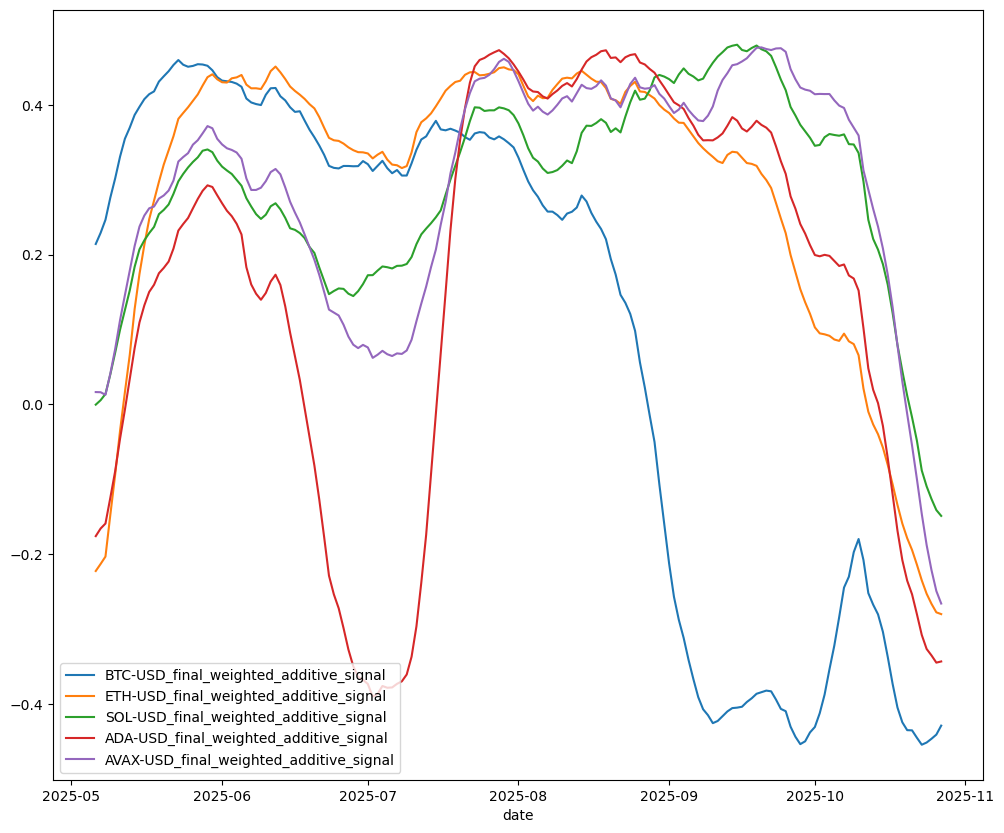

In [44]:
df_final[raw_signal_cols].plot(figsize=(12,10))

<Axes: xlabel='date'>

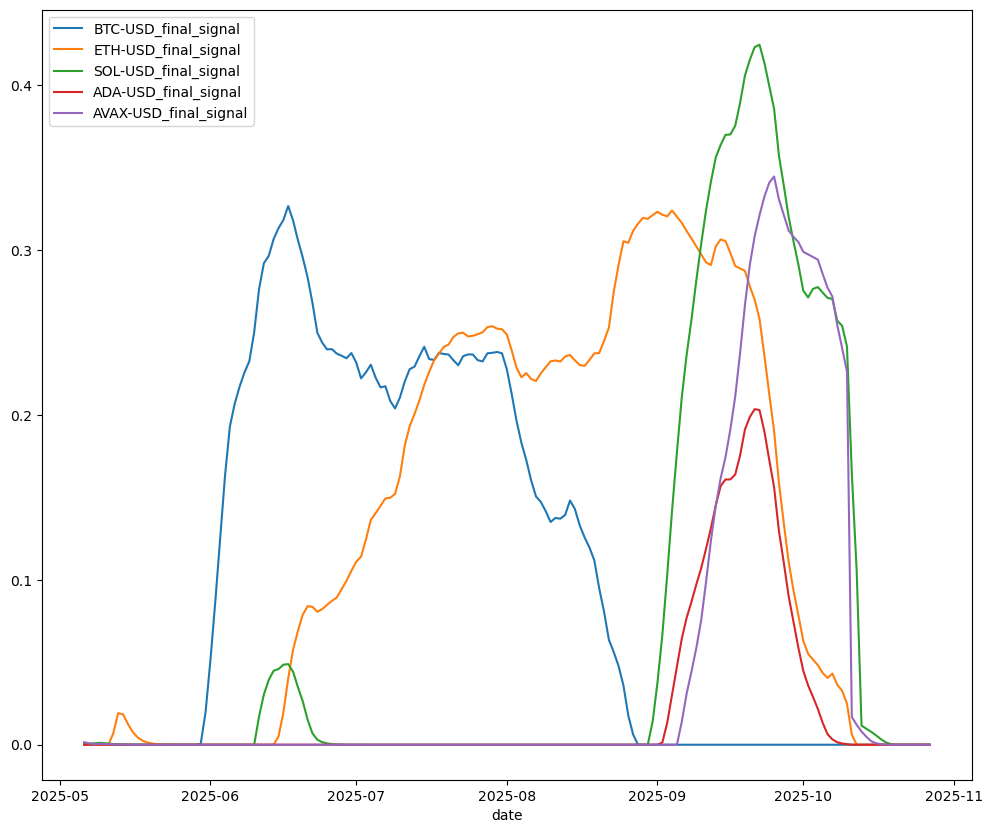

In [42]:
df_final[signal_cols].plot(figsize=(12,10))

In [79]:
datetime.now(timezone.utc).date()

datetime.date(2025, 10, 19)

In [99]:
pd.Timestamp('2025-10-15', tz='UTC').normalize()#.isoformat().replace('+00:00', 'Z')#.date()

Timestamp('2025-10-15 00:00:00+0000', tz='UTC')

In [ ]:
now = utc_now()
today = now.date()

In [111]:
granularity = 'ONE_DAY'  # daily enum expected by SDK

client = cn.get_coinbase_rest_api_client(portfolio_name='Trend Following')

# Inclusive start-of-day on the 15th; end is exclusive => add one day to include the 17th
start_dt = pd.Timestamp('2025-10-15', tz='UTC').normalize()
end_dt   = pd.Timestamp('2025-10-18', tz='UTC').normalize()  # exclusive

start_unix = int(start_dt.timestamp())  # e.g., 1739558400
end_unix   = int(end_dt.timestamp())    # e.g., 1739817600

candle_list = client.get_candles(
    product_id='BTC-USD',
    start=str(start_unix),   # pass as str or int; both work
    end=str(end_unix),
    granularity=granularity,
).candles

# Process candle data
candle_data = []
for candles in candle_list:
    candle_info = {
        'date': candles['start'],
        'low': float(candles['low']),
        'high': float(candles['high']),
        'open': float(candles['open']),
        'close': float(candles['close']),
        'volume': float(candles['volume'])
    }
    candle_data.append(candle_info)

# Convert to DataFrame
df_candles = pd.DataFrame(candle_data).sort_values('date')
# df_candles['date'] = pd.to_datetime(df_candles['date'], unit='s').dt.date
# df_candles = df_candles.set_index('date')

In [115]:
df_candles['date'] = (
    pd.to_datetime(pd.to_numeric(df_candles['date'], errors='coerce'), unit='s', utc=True)
      .dt.tz_convert(None)   # optional: drop tz
      .dt.date               # if you truly want Python date objects
)

In [117]:
df_candles

,date,low,high,open,close,volume
3,2025-10-15,110185.87,113671.99,113072.18,110804.12,7440.037825
2,2025-10-16,107464.53,112021.07,110804.11,108198.00,14792.787545
1,2025-10-17,103516.75,109269.97,108197.99,106463.30,13824.344635
0,2025-10-18,106357.69,107535.68,106462.09,107208.91,3552.609595


In [119]:
df_candles.date.iloc[0]

datetime.date(2025, 10, 15)

In [125]:
df_atr = calculate_average_true_range_live(date=date, ticker='BTC-USD', rolling_atr_window=20)

In [137]:
df_atr.tail()

,BTC-USD_low,BTC-USD_high,BTC-USD_open,BTC-USD_close,BTC-USD_volume,BTC-USD_t_1_close,BTC-USD_high-low,BTC-USD_high-close,BTC-USD_low-close,BTC-USD_true_range_price,BTC-USD_20_avg_true_range_price
date,,,,,,,,,,,
2025-10-15,110185.87,113671.99,113072.18,110804.12,7440.037825,113068.00,3486.12,603.99,2882.13,3486.12,4349.027971
2025-10-16,107464.53,112021.07,110804.11,108198.00,14792.787545,110804.12,4556.54,1216.95,3339.59,4556.54,4266.846259
2025-10-17,103516.75,109269.97,108197.99,106463.30,13824.344635,108198.00,5753.22,1071.97,4681.25,5753.22,4294.436139
2025-10-18,106357.69,107535.68,106462.09,107208.91,3552.609595,106463.30,1177.99,1072.38,105.61,1177.99,4433.367936
2025-10-19,106091.25,109499.00,107208.91,108864.93,4756.816338,107208.91,3407.75,2290.09,1117.66,3407.75,4123.331942


In [139]:
atr = df_atr.loc[date, f'{'BTC-USD'}_{20}_avg_true_range_price']

In [131]:
atr = df_atr[f'{'BTC-USD'}_{20}_avg_true_range_price'].loc[date]

In [141]:
atr

4123.331941793534

## Generate Rebalance Orders

In [ ]:
def build_rebalance_orders(desired_positions, date, current_positions, client, order_type, limit_price_buffer=0.0):
    """
    Build market orders for new trades. You may switch to limit orders.
    Returns a list of dicts: {product_id, side, type, size, client_order_id}
    """
    orders = []
    today_str = date.strftime("%Y%m%d")
    
    for ticker, d in desired_positions.items():
        raw_notional = float(d.get("new_trade_notional", 0.0))
        if abs(raw_notional) < 1e-9:
            continue

        side = 'buy' if raw_notional > 0 else 'sell'
        mid_px = current_positions[ticker]['ticker_mid_price']#price_lookup(t)
        if not (np.isfinite(mid_px) and mid_px > 0):
            continue

        prod_specs = cn.get_product_meta(client, ticker)
        base_inc  = prod_specs["base_increment"]
        base_min  = prod_specs["base_min_size"]
        quote_min = prod_specs["quote_min_size"]    # min notional in quote currency
        price_inc = prod_specs["price_increment"]
        
        # Size in BASE currency: |notional| / price
        raw_size = abs(raw_notional) / mid_px

        # Quantize size to base_increment
        q_size = cn.round_down(raw_size, base_inc)

        # Enforce base_min_size
        if q_size < base_min:
            # Try rounding up once (only for buys), else skip as dust
            if side == "buy":
                q_size_up = cn.round_up(raw_size, base_inc)
                if q_size_up >= base_min:
                    q_size = q_size_up
                else:
                    # still dust, skip
                    continue
            else:
                # sell smaller than min size => skip (or you may aggregate to a later day)
                continue

        # Enforce quote_min_size (notional)
        q_notional = q_size * mid_px
        if quote_min and q_notional < quote_min:
            # For buys, see if one more increment clears the bar
            if side == "buy":
                q_size_up = cn.round_up((quote_min / mid_px), base_inc)
                if q_size_up * mid_px >= quote_min:
                    q_size = q_size_up
                    q_notional = q_size * mid_px
                else:
                    continue
            else:
                # for sells, if position leftover < min you might need to fully close later; skip now
                continue

        # Prepare order dict
        cl_order_id = f"{ticker}-{today_str}-rebalance-{uuid.uuid4().hex[:8]}"

        order = {
            "product_id": ticker,
            "side": side,
            "type": order_type,  # "market" (default) or "limit"
            "size": float(q_size),  # BASE units
            "client_order_id": cl_order_id,
        }

        if order_type == "limit":
            # simple passive limit example: improve for real routing
            if side == "buy":
                # pay up to mid*(1 + buffer)
                px = mid_px * (1 + abs(limit_price_buffer))
            else:
                # sell no worse than mid * (1 - buffer)
                px = mid_px * (1 - abs(limit_price_buffer))
            if price_inc:
                px = cn.round_to_increment(px, price_inc)
            order["limit_price"] = float(px)
            order["time_in_force"] = "GTC"

        orders.append(order)
        
    return orders

def submit_daily_rebalance_orders(client, orders, *, preview=True):
    results = []
    for od in orders:
        try:
            if preview:
                r = client.preview_order(
                    product_id=od["product_id"],
                    side=od["side"],
                    order_configuration=od["order_configuration"],
                )
            else:
                r = client.create_order(
                    client_order_id=od["client_order_id"],
                    product_id=od["product_id"],
                    side=od["side"],
                    order_configuration=od["order_configuration"],
                )
            results.append({"ok": True, "request": od, "response": cn._as_dict(r)})
        except Exception as e:
            results.append({"ok": False, "request": od, "error": f"{type(e).__name__}: {e}"})
    return results

In [ ]:
ticker_list = cfg['universe']['tickers']
portfolio_name = cfg['portfolio']['name']

# --- 2) Live portfolio state -------------------------------------------------
## Get Portfolio Positions and Cash
print(f'Start Time: {datetime.now()}')
## Create Coinbase Client & Portfolio UUID
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)
portfolio_uuid = cn.get_portfolio_uuid(client, portfolio_name=portfolio_name)

print(f'Get Portfolio Equity and Cash Time: {datetime.now()}')
## Get Live Portfolio Equity
portfolio_equity, available_cash = cn.get_live_portfolio_equity_and_cash(client=client, portfolio_name=portfolio_name)

print(f'Get Current Positions Time: {datetime.now()}')
## Get Current Positions using Mid-Price
## TODO: CHECK TO SEE IF THE MID-PRICE BEING CAPTURED IS ACCURATE FROM COINBASE
current_positions = cn.get_current_positions_from_portfolio(client, ticker_list=ticker_list, portfolio_name=portfolio_name)

In [ ]:
rebal_orders = build_rebalance_orders(desired_trades, date, current_positions, client, order_type='market', limit_price_buffer=0.0)
cn.preview_orders(client, rebal_orders)

In [ ]:
submit_daily_rebalance_orders(client, rebal_orders, preview=True)

In [ ]:
current_positions

In [ ]:
desired_trades

In [ ]:
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
df_final[target_notional_cols].tail()

## Close Dust Positions

In [ ]:
def should_close_dust(df, date, actual_notional, min_notional_abs, pct_of_portfolio=0.002):
    """Close if notional is very small in absolute terms OR as a % of portfolio."""
    total_portfolio_value = float(df.loc[date, 'total_portfolio_value'])
    return (abs(actual_notional) < float(min_notional_abs)) or (abs(actual_notional) < pct_of_portfolio * total_portfolio_value)

def estimated_close_cost_usd(notional_usd, transaction_cost_est, passive_trade_rate, extra_slippage_bp=0.0):
    """
    Estimated T-Cost in USD
    """
    est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))
    fee_cost = notional_usd * est_fees
    return fee_cost

def build_dust_close_orders(client, df, date, ticker_list, min_trade_notional_abs, 
                            max_cost_usd=0.05,               # don't spend >$0.05 to clean dust
                            transaction_cost_est=0.001,
                            passive_trade_rate=0.05,
                            use_ioc=True):
    """
    Flatten tiny residual positions to zero, but only if expected cost is tiny.
    Sends marketable LIMIT IOC (safer) when use_ioc=True; else MARKET.
    """
    orders = []
    price_map = cn.get_price_map(client, ticker_list)
    for ticker in ticker_list:
        actual_notional = float(df.loc[date, f'{ticker}_actual_position_notional'])
        if not should_close_dust(df, date, actual_notional, min_trade_notional_abs):
            continue

        size_now = float(df.loc[date, f'{ticker}_actual_position_size'])
        if abs(size_now) < 1e-12:
            continue

        # Check product constraints
        specs = cn.get_product_meta(client, ticker)  # should return price_increment, base_increment, quote_min_size, best_bid/ask if you include it
        quote_min = float(specs.get('quote_min_size') or 0.0)
        if abs(actual_notional) < quote_min:
            # below exchange min; skip (or accumulate until above)
            continue

        # Cost guardrail
        est_cost = estimated_close_cost_usd(abs(actual_notional), transaction_cost_est, passive_trade_rate, extra_slippage_bp=0.0)
        if est_cost > max_cost_usd:
            continue

        side = 'sell' if size_now > 0 else 'buy'
        base_sz = cn.round_to_increment(abs(size_now), float(specs['base_increment']))

        if use_ioc:
            # marketable limit: cross the spread slightly to fill now, avoid wild prints
            # You'll need a fresh price; if your specs() doesn’t return bid/ask, fetch your own last/quote.
            best_bid = float(price_map[ticker]['best_bid_price'] or 0.0)
            best_ask = float(price_map[ticker]['best_ask_price'] or 0.0)
            inc = float(specs['price_increment'])
            if side == 'sell':
                limit_px = cn.round_down(best_bid if best_bid else 0, inc)
                tif = "IOC"
                order_cfg = {"limit_limit_ioc": {"base_size": f"{base_sz}", "limit_price": f"{limit_px}", "post_only": False}}
                otype = "limit"
            else:
                limit_px = cn.round_up(best_ask if best_ask else 0, inc)
                tif = "IOC"
                order_cfg = {"limit_limit_ioc": {"base_size": f"{base_sz}", "limit_price": f"{limit_px}", "post_only": False}}
                otype = "limit"
        else:
            # pure market
            order_cfg = {"market_market_ioc": {"base_size": f"{base_sz}"}}
            otype = "market"

        orders.append({
            "product_id": ticker,
            "side": side.upper(),
            "type": otype,
            "size": base_sz,
            "client_order_id": f"{ticker}-{pd.Timestamp(date).strftime('%Y%m%d')}-dustclose",
            # If you use your create_order helpers, you can pass the generic dict,
            # or directly call client.create_order with order_configuration:
            "order_configuration": order_cfg,
        })

        # Reflect intended flatten in df (optional; you might prefer to do this post-trade)
        df.loc[date, f'{ticker}_actual_position_notional'] = 0.0
        df.loc[date, f'{ticker}_actual_position_size'] = 0.0

    return orders


def submit_dust_close_orders(client, orders, preview=True):
    """
    Use your helpers directly if you want; here we call Coinbase endpoints
    with the already-built order_configuration.
    Returns a list of per-order results.
    """
    results = []
    for od in orders:
        try:
            if preview:
                r = client.preview_order(
                    product_id=od["product_id"],
                    side=od["side"],
                    order_configuration=od["order_configuration"],
                )
            else:
                r = client.create_order(
                    client_order_id=od["client_order_id"],
                    product_id=od["product_id"],
                    side=od["side"],
                    order_configuration=od["order_configuration"],
                )
            results.append({"ok": True, "request": od, "response": r})
        except Exception as e:
            results.append({"ok": False, "request": od, "error": f"{type(e).__name__}: {e}"})
    return results

In [ ]:
should_close_dust(df_final, date, actual_notional=43.4995522227813, min_notional_abs=10, pct_of_portfolio=0.002)

In [ ]:
min_trade_notional_abs = cfg['execution_and_costs']['min_trade_notional_abs']
dust_close_orders = build_dust_close_orders(client, df_final, date, ticker_list, min_trade_notional_abs)
dust_close_orders

In [ ]:
min_trade_notional_abs

In [ ]:
submit_dust_close_orders(client, dust_close_orders, preview=True)

## Send/Update Stop Limit Order

In [ ]:
cn.list_open_stop_orders(client, product_id='SOL-USD')

In [ ]:
def update_trailing_stop_chandelier(
    client, df, ticker, date,
    highest_high_window=56, rolling_atr_window=20, atr_multiplier=2.5,
    stop_loss_replace_threshold_ticks=1, client_id_prefix="stop-",
    limit_price_buffer=0.005
):
    # --- specs & compute desired stop ---
    specs = cn.get_product_meta(client, product_id=ticker)
    tick  = float(specs['price_increment'])
    result_dict = {}

    stop_today = float(chandelier_stop_long(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier))
    stop_prev  = df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float)).shift(1).loc[date]

    # monotone ratchet
    candidates   = [x for x in (stop_prev, stop_today) if np.isfinite(x)]
    desired_stop = max(candidates) if candidates else stop_today
    desired_stop = cn.round_to_increment(desired_stop, tick)

    # skip if not a meaningful ratchet
    threshold = (stop_prev if np.isfinite(stop_prev) else -np.inf) + (stop_loss_replace_threshold_ticks * tick)
    if np.isfinite(stop_prev) and desired_stop < threshold:
        df.loc[date, f'{ticker}_stop_loss'] = float(stop_prev)
        result_dict = {
            "ok": True,
            "action": "skip",
            "reason": "no_ratchet",
            "open_stop_price": float(stop_prev),
            "stop_today": float(stop_today),
            "desired_stop": float(desired_stop),
            "tick": float(tick)
        }
        return result_dict

    # position size
    try:
        pos_size = float(df.loc[date, f'{ticker}_actual_position_size'])
    except Exception:
        pos_map = (cn.get_current_positions_from_portfolio(client, [ticker]) or {}).get(ticker, {})
        pos_size = float(pos_map.get('ticker_qty', 0.0))
    if pos_size <= 0:
        df.loc[date, f'{ticker}_stop_loss'] = float(desired_stop)
        result_dict = {
            "ok": True,
            "action": "skip",
            "reason": "no_position",
            "open_stop_price": float(stop_prev) if np.isfinite(stop_prev) else None,
            "stop_today": float(stop_today),
            "desired_stop": float(desired_stop),
            "tick": float(tick)
        }
        return result_dict

    client_order_id = f"{client_id_prefix}{ticker}-{date:%Y%m%d}-{int(round(desired_stop / tick))}"

    # --- PREVIEW FIRST (do NOT cancel yet) ---
    pv = cn.place_stop_limit_order(
        client=client,
        product_id=ticker,
        side="sell",
        stop_price=desired_stop,
        size=pos_size,
        client_order_id=client_order_id,
        buffer_bps=50,
        preview=True,
        price_increment=specs["price_increment"],
        base_increment=specs["base_increment"],
        quote_min_size=specs["quote_min_size"]
    )
    pv_d = _as_dict(pv)
    errs = pv_d.get("errs") or []

    if errs:
        # keep old stop; report clearly
        df.loc[date, f'{ticker}_stop_loss'] = float(stop_prev)  # persist your computed target for next run
        result_dict = {
            "ok": False,
            "action": "no_change",
            "reason": "preview_error",
            "preview_errors": errs,  # e.g., ["PREVIEW_STOP_PRICE_ABOVE_LAST_TRADE_PRICE"]
            "open_stop_price": float(stop_prev) if np.isfinite(stop_prev) else None,
            "stop_today": float(stop_today),
            "desired_stop": float(desired_stop),
            "tick": float(tick),
            "preview_id": pv_d.get("preview_id")
        }
        return result_dict

    # --- PREVIEW OK → now cancel existing stops, then place live ---
    try:
        open_orders = cn.list_open_stop_orders(client, product_id=ticker) or []
        for o in open_orders:
            otype = str(o.get('type') or '').lower()
            if ('stop' in otype) or (o.get('stop_price') is not None):
                cancel_order_by_id(client, order_id=o['order_id'])
    except Exception as e:
        # still attempt to place the new one
        print(f"[warn] cancel stop failed for {ticker}: {e}")

    cr = place_stop_limit_order(
        client=client,
        product_id=ticker,
        side="sell",
        stop_price=desired_stop,
        size=pos_size,
        client_order_id=client_order_id,
        buffer_bps=50,
        preview=False,  # LIVE
        price_increment=specs["price_increment"],
        base_increment=specs["base_increment"],
        quote_min_size=specs["quote_min_size"]
    )
    cr_d = _as_dict(cr)

    df.loc[date, f'{ticker}_stop_loss'] = float(desired_stop)
    result_dict = {
        "ok": True,
        "action": "replaced",
        "client_order_id": client_order_id,
        "new_order_id": cr_d.get("response", {}).get("order_id") or cr_d.get("order_id"),
        "desired_stop": float(desired_stop),
        "pos_size": float(pos_size),
    }
    
    return result_dict

In [ ]:
cfg = load_prod_strategy_config(strategy_version='v0.1.0')
highest_high_window = cfg['risk_and_sizing']['highest_high_window']
rolling_atr_window = cfg['risk_and_sizing']['rolling_atr_window']
atr_multiplier = cfg['risk_and_sizing']['atr_multiplier']
for ticker in ticker_list:
    result_dict = update_trailing_stop_chandelier(client, df_final, ticker, date, highest_high_window=highest_high_window, rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier, stop_loss_replace_threshold_ticks=1, 
                                                  client_id_prefix="stop-", limit_price_buffer=0.005)
    print(ticker, result_dict)

In [ ]:
date = datetime.now(timezone.utc).date()

# Coinbase Tests for Order Placement

In [ ]:
# Cell 10 — compute micro size that meets min notional but stays small

def compute_test_size(client, product_id, max_usd=5.0):
    specs = get_product_meta(client, product_id)
    # Pull latest ticker price
    t = client.get_product(product_id=product_id)  # if you have a ticker endpoint, prefer that
    # last = float((t.get("price") or t.get("last") or t.get("mark_price") or 0.0) if isinstance(t, dict) else 0.0)
    last = float(getattr(t, 'price'))
    last = last if last > 0 else 5.0  # fallback
    
    # meet quote_min_size and max_usd
    min_quote = float(specs["quote_min_size"])
    price_inc = float(specs["price_increment"])
    base_inc  = float(specs["base_increment"])
    target_quote = max(min_quote, min(max_usd, 10*min_quote))  # pick something small but safe
    
    raw_size = target_quote / last
    size = _round_down(raw_size, base_inc)
    return size, specs, last


In [ ]:
compute_test_size(client, product_id='BTC-USD')

In [ ]:
4.378e-05 * 114205.22

## Test 1: Preview & Create tiny LIMIT Buy Order

In [ ]:
portfolio_name = cfg['portfolio']['name']
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)

# Choose a small-notional product (low price helps); SOL-USD or ADA-USD are good.
PRODUCT_ID = "SOL-USD"

# Safety: keep sizes tiny for live testing
MAX_TEST_USD = 5.00

In [ ]:
## Get Live Portfolio Equity
portfolio_equity, available_cash = get_live_portfolio_equity_and_cash(client=client, portfolio_name=portfolio_name)

## Get Portfolio Breakdown
df_portfolio_breakdown = cn.get_portfolio_breakdown(client, portfolio_uuid=portfolio_uuid)

## Get Current Positions using Mid-Price
## TODO: CHECK TO SEE IF THE MID-PRICE BEING CAPTURED IS ACCURATE FROM COINBASE
current_positions = get_current_positions_from_portfolio(client, ticker_list=ticker_list,
                                                         portfolio_name=portfolio_name)

In [ ]:
print(f'Portfolio Equity: {portfolio_equity}, Available Cash: {available_cash}')

In [ ]:
df_portfolio_breakdown

In [ ]:
current_positions

In [ ]:
# Cell 11 — Preview & Create (LIMIT buy)

size, specs, last = compute_test_size(client, PRODUCT_ID, max_usd=MAX_TEST_USD)
limit_price = _round_down(last * 0.98, specs["price_increment"])  # try to get filled eventually; tweak as you like

order = {
    "product_id": PRODUCT_ID,
    "side": "BUY",
    "type": "limit",
    "size": size,
    "limit_price": limit_price,
    "time_in_force": "GTC",
    "post_only": False,
    "client_order_id": f"test-{PRODUCT_ID}-{int(time.time())}"
}

print("Preview:")
pv = preview_order(client, order)
print(json.dumps(pv, indent=2))

if pv["ok"]:
    print("\nCreate:")
    cr = create_order(client, order, preview_first=False)
    print(json.dumps(cr, indent=2))
else:
    print("Preview failed; not creating.")


## List Open Orders

In [ ]:
open_orders = list_open_stop_orders(client, product_id=PRODUCT_ID)
open_orders

In [ ]:
try:
    # Path A: some SDKs use list_orders(product_id=..., order_status=[...])
    res = client.list_orders(product_id=PRODUCT_ID, order_status=['OPEN'])
    raw = res['orders']
except Exception:
    raw = []

In [ ]:
res

In [ ]:
raw

In [ ]:
# 2) Normalize & filter only stops
orders = []
for o in raw:
    otype      = o['order_type'].lower()
    stop_price = o['stop_price'] or o['stopPrice']
    # if ('stop' in otype) or (stop_price is not None):
    orders.append({
        'order_id'       : o['order_id'] or o['id'],
        'client_order_id': o['client_order_id'] or o['clientOrderId'],
        'product_id'     : o['product_id'] or o['productId'] or product_id,
        'side'           : o['side'],
        'type'           : o['order_type'] or o['type'],
        'stop_price'     : float(stop_price) if stop_price is not None else np.nan,
        'created_at'     : o['created_time'] or o['created_at'],
    })

In [ ]:
orders

## Cancel Open Order

In [ ]:
# --- SIMPLE Coinbase Advanced Trade order helpers (object-attribute style) ---

def _flatten_cfg(order):
    """
    Pull common fields from order.order_configuration without guessing types.
    Looks at the first (and usually only) sub-config present.
    """
    cfg = getattr(order, "order_configuration", None) or {}
    if not isinstance(cfg, dict) or not cfg:
        return {}

    # take the first sub-config dict (e.g., 'limit_limit_gtc', 'stop_limit_stop_limit_gtc', etc.)
    key, sub = next(iter(cfg.items()))
    if not isinstance(sub, dict):
        return {}

    # extract common fields if present
    out = {}
    if "base_size"   in sub: out["base_size"]   = sub["base_size"]
    if "limit_price" in sub: out["limit_price"] = sub["limit_price"]
    if "stop_price"  in sub: out["stop_price"]  = sub["stop_price"]
    if "stop_direction" in sub: out["stop_direction"] = sub["stop_direction"]
    if "post_only"   in sub: out["post_only"]   = sub["post_only"]
    out["config_key"] = key  # helpful to know which config it was
    return out

def norm_order(o):
    """Normalize a coinbase.rest.types.common_types.Order into a plain dict."""
    data = {
        "order_id":        o.order_id,
        "client_order_id": getattr(o, "client_order_id", None),
        "product_id":      getattr(o, "product_id", None),
        "side":            getattr(o, "side", None),
        "type":            getattr(o, "order_type", None),
        "status":          getattr(o, "status", None),
        "time_in_force":   getattr(o, "time_in_force", None),
        "created_time":    getattr(o, "created_time", None),
        "filled_size":     getattr(o, "filled_size", None),
        "average_price":   getattr(o, "average_filled_price", None),
    }
    data.update(_flatten_cfg(o))
    return data

def list_open_orders(client, product_id: str | None = None):
    out, cursor = [], None
    while True:
        kw = {"order_status": ["OPEN"]}
        if product_id: kw["product_id"] = product_id
        if cursor:     kw["cursor"] = cursor

        res = client.list_orders(**kw)           # {'orders': [Order,...], 'cursor': '', 'has_next': False}
        orders = res['orders']
        out.extend({
            "order_id":        o.order_id,
            "client_order_id": getattr(o, "client_order_id", None),
            "product_id":      getattr(o, "product_id", None),
            "side":            getattr(o, "side", None),
            "type":            getattr(o, "order_type", None),
            "status":          getattr(o, "status", None),
            "time_in_force":   getattr(o, "time_in_force", None),
            "created_time":    getattr(o, "created_time", None),
            "filled_size":     getattr(o, "filled_size", None),
            "average_price":   getattr(o, "average_filled_price", None),
        } for o in orders)

        cursor   = res['cursor']#res.get("cursor") or None     # '' -> None
        has_next = bool(res["has_next"])#bool(res.get("has_next", False))
        if not cursor or not has_next:
            break
    return out

def find_open_by_client_id(client, client_order_id: str, product_id: str | None = None):
    """Find one OPEN order by your client_order_id."""
    for o in list_open_orders(client, product_id=product_id):
        if o.get("client_order_id") == client_order_id:
            return o
    return None

def cancel_order_by_id(client, order_id: str):
    # MUST be a list
    return client.cancel_orders(order_ids=[order_id])

def cancel_order_by_client_id(client, client_order_id: str, product_id: str | None = None):
    # find the open order, then cancel by order_id
    for o in list_open_orders(client, product_id=product_id):
        if o["client_order_id"] == client_order_id:
            return cancel_order_by_id(client, o["order_id"])
    return {"ok": False, "error": "not_found", "client_order_id": client_order_id}

def cancel_all_open_orders(client, product_id: str | None = None):
    """Cancel every OPEN order (optionally for a single product)."""
    orders = list_open_orders(client, product_id=product_id)
    results = []
    for o in orders:
        oid = o.get("order_id")
        if oid:
            results.append(cancel_order_by_id(client, oid))
    return results


In [ ]:
o = find_open_by_client_id(client, client_order_id, product_id=product_id)

In [ ]:
o["order_id"]

In [ ]:
for o in open_orders:
    oid = o.get("order_id")
    print(oid)

In [ ]:
open_orders = list_open_orders(client, product_id='SOL-USD')

In [ ]:
open_orders

In [ ]:
client_order_id = 'test-SOL-USD-1760369132'

In [ ]:
client_order_id = find_open_by_client_id(client, client_order_id, product_id=None)['client_order_id']

In [ ]:
client_order_id

In [ ]:
find_open_by_client_id(client, client_order_id, product_id=None)

In [ ]:
find_open_by_client_id(client, client_order_id=None, product_id=PRODUCT_ID)

In [ ]:
## Cancel Order by Client Order Id
cancel_order_by_client_id(client, client_order_id, product_id=None)

In [ ]:
## Cancel Order by Client Order Id
cancel_order_by_client_id(client, client_order_id, product_id=None)

In [ ]:
list_open_stop_orders(client, product_id=PRODUCT_ID)

## Test 2: Create a STOP-LIMIT sell to protect the tiny position

In [ ]:
current_positions = get_current_positions_from_portfolio(client, ticker_list=ticker_list,
                                                         portfolio_name=portfolio_name)

In [ ]:
current_positions

In [ ]:
# Cancel the old order if you have its id:
# client.cancel_order(order_id="<your_order_id>")

# Compute a tiny, valid size (≈ $5 notional, rounded to increments)
size, specs, last = compute_test_size(client, PRODUCT_ID, max_usd=5.00)

# Place a small MARKET buy
mrk = create_order(client, {
    "product_id": PRODUCT_ID,
    "side": "BUY",
    "type": "market",
    "size": size,
    "client_order_id": f"test-mkt-{PRODUCT_ID}-{int(time.time())}"
}, preview_first=False)
print(mrk)

In [ ]:
current_positions = get_current_positions_from_portfolio(client, ticker_list=ticker_list,
                                                         portfolio_name=portfolio_name)
avail_qty = float(current_positions[PRODUCT_ID].get("ticker_qty", 0.0))
print("Available SOL:", avail_qty)
current_positions

In [ ]:
## Preview Stop Limit Order

specs = get_product_meta(client, PRODUCT_ID)
# choose a stop ~2% below current price
stop_price = _round_down(last * 0.98, specs["price_increment"])
pos_size   = _round_down(avail_qty, specs["base_increment"])
cid = f"stop-{PRODUCT_ID}-{int(time.time())}"

pv = place_stop_limit_order(
    client=client,
    product_id=PRODUCT_ID,
    side="SELL",
    stop_price=stop_price,
    size=pos_size,
    client_order_id=cid,
    buffer_bps=50,
    preview=True,
    price_increment=specs["price_increment"],
    base_increment=specs["base_increment"],
    quote_min_size=specs["quote_min_size"],
)
print(_as_dict(pv))

# If ok, place live:
# cr = place_stop_limit_order(..., preview=False, ...)
# print(_as_dict(cr))


In [ ]:
## Place Stop Limit Order

specs = get_product_meta(client, PRODUCT_ID)
# choose a stop ~2% below current price
stop_price = _round_down(last * 0.98, specs["price_increment"])
pos_size   = _round_down(avail_qty, specs["base_increment"])
cid = f"stop-{PRODUCT_ID}-{int(time.time())}"

pv = place_stop_limit_order(
    client=client,
    product_id=PRODUCT_ID,
    side="SELL",
    stop_price=stop_price,
    size=pos_size,
    client_order_id=cid,
    buffer_bps=50,
    preview=False,
    price_increment=specs["price_increment"],
    base_increment=specs["base_increment"],
    quote_min_size=specs["quote_min_size"],
)
print(_as_dict(pv))

# If ok, place live:
# cr = place_stop_limit_order(..., preview=False, ...)
# print(_as_dict(cr))


In [ ]:
0.04/(0.01691215*204.52)

## Test 3: List Open Stop Orders

In [ ]:
list_open_stop_orders(client, product_id=PRODUCT_ID)

## Test 4: Get Fills for Test Window

In [ ]:
end = dt.datetime.now(dt.timezone.utc)
start = end - dt.timedelta(days=5000)
fills = get_fills_with_client_ids(client, "SOL-USD", start, end, client_id_prefix=None)
fills

In [ ]:
## Fills from Stop Loss Breach
end = dt.datetime.now(dt.timezone.utc)
start = end - dt.timedelta(days=5)
fills = get_fills_with_client_ids(client, "SOL-USD", start, end, client_id_prefix='stop')
fills

## Test 5: Update/Replace a trailing stop (Chandelier)

In [ ]:
PRODUCT_ID = "SOL-USD"
PREFIX = "stop-"  # your function already uses this
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)

# sanity: you do have a live position
pos = get_current_positions_from_portfolio(client, ticker_list=[PRODUCT_ID], portfolio_name=portfolio_name)[PRODUCT_ID]
print("qty:", pos["ticker_qty"], "avg:", pos["ticker_mid_price"])


In [ ]:
pos

In [ ]:
ticker = 'SOL-USD'
update_trailing_stop_chandelier(client, df, ticker, date, highest_high_window=56, rolling_atr_window=20, atr_multiplier=2.5, stop_loss_replace_threshold_ticks=1, 
                                client_id_prefix="stop-", limit_price_buffer=0.005)

In [ ]:
ticker = 'SOL-USD'
update_trailing_stop_chandelier(client, df, ticker, date, highest_high_window=56, rolling_atr_window=20, atr_multiplier=2.5, stop_loss_replace_threshold_ticks=1, 
                                client_id_prefix="stop-", limit_price_buffer=0.005)

In [ ]:
print(f'Get Portfolio Equity and Cash Time: {datetime.now()}')
## Get Live Portfolio Equity
portfolio_equity, available_cash = get_live_portfolio_equity_and_cash(client=client, portfolio_name=portfolio_name)

print(f'Get Portfolio Position Breakdown Time: {datetime.now()}')
## Get Portfolio Breakdown
df_portfolio_breakdown = cn.get_portfolio_breakdown(client, portfolio_uuid=portfolio_uuid)

print(f'Get Current Positions Time: {datetime.now()}')
## Get Current Positions using Mid-Price
## TODO: CHECK TO SEE IF THE MID-PRICE BEING CAPTURED IS ACCURATE FROM COINBASE
current_positions = get_current_positions_from_portfolio(client, ticker_list=ticker_list, portfolio_name=portfolio_name)

In [ ]:
actual_position_size_cols = [f'{ticker}_actual_position_size' for ticker in ticker_list]
actual_position_notional_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
df[actual_position_cols + actual_position_notional_cols].tail()

In [ ]:
df[stop_loss_cols].tail()

In [ ]:
# OPTIONAL: a one-line clamp to ensure preview fails (stop above last)
last = float(get_product_meta(client, PRODUCT_ID)["last"]) if "last" in get_product_meta(client, PRODUCT_ID) else None
# or fetch your last via your own price function
# desired_stop = max(desired_stop, last + 0.5)  # force fail; remove after test
last

In [ ]:
get_product_meta(client, PRODUCT_ID)

In [ ]:
date = pd.Timestamp('2025-10-13').date()#datetime.now(timezone.utc).date()

In [ ]:
date

In [ ]:
res = update_trailing_stop_chandelier(
    client, df, ticker=PRODUCT_ID, date=date,
    highest_high_window=56, rolling_atr_window=20, atr_multiplier=2.5,
    stop_loss_replace_threshold_ticks=1, client_id_prefix=PREFIX
)
res


In [ ]:
res = update_trailing_stop_chandelier(
    client, df, ticker=PRODUCT_ID, date=date,
    highest_high_window=56, rolling_atr_window=20, atr_multiplier=3,
    stop_loss_replace_threshold_ticks=1, client_id_prefix=PREFIX
)
res


In [ ]:
float(chandelier_stop_long(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier=3))

In [ ]:
open_stops = list_open_stop_orders(client, PRODUCT_ID)
open_stops  # you should see stop_price, limit_price, base_size, etc.


In [ ]:
import datetime as dt
end = dt.datetime.now(dt.timezone.utc)
start = end - dt.timedelta(days=1)
fills = get_fills_with_client_ids(client, PRODUCT_ID, start, end, client_id_prefix=PREFIX)
fills  # will show trade_id, order_id, client_order_id=stop-..., price/size/time


In [ ]:
df[stop_loss_cols].tail()

In [ ]:
df_portfolio_breakdown

In [ ]:
current_positions

In [ ]:
# Cell 12 — Stop-LIMIT (sell) for the tiny buy

# Get a fresh price anchor
_, specs, last = compute_test_size(client, PRODUCT_ID, max_usd=MAX_TEST_USD)

# Aim stop ~2% below last, limit 0.5% further via buffer_bps=50
stop_price = _round_down(last * 0.98, specs["price_increment"])
pos_size = size  # protect what we (expect to) own

client_order_id = f"stop-{PRODUCT_ID}-{int(time.time())}"
print("Preview stop-limit:")
st_pv = place_stop_limit_order(
    client=client,
    product_id=PRODUCT_ID,
    side="SELL",
    stop_price=stop_price,
    size=pos_size,
    client_order_id=client_order_id,
    buffer_bps=50,
    preview=True,
    price_increment=specs["price_increment"],
    base_increment=specs["base_increment"],
    quote_min_size=specs["quote_min_size"]
)
print(json.dumps(_as_dict(st_pv), indent=2))

# If preview looks good, uncomment to create live:
# st_cr = place_stop_limit_order(
#     client=client,
#     product_id=PRODUCT_ID,
#     side="SELL",
#     stop_price=stop_price,
#     size=pos_size,
#     client_order_id=client_order_id,
#     buffer_bps=50,
#     preview=False,
#     price_increment=specs["price_increment"],
#     base_increment=specs["base_increment"],
#     quote_min_size=specs["quote_min_size"]
# )
# print(json.dumps(_as_dict(st_cr), indent=2))


In [ ]:
import math, time, uuid
from typing import Dict, Any

def get_product_meta(client, product_id: str):
    """
    Returns increments & mins for sizing/price rounding.
    """
    p = client.get_product(product_id)  # Advanced Trade: /api/v3/brokerage/products/{product_id}
    # Public/List Public Products also exposes similar fields.
    # Fields include base_increment, quote_increment, base_min_size, quote_min_size, price_increment, etc.
    return {
        "base_increment": float(p.base_increment),                                                    ## Minimum amount base value can be increased or decreased at once.
        "quote_increment": float(p.quote_increment) if getattr(p, "quote_increment", None) else None, ## Minimum amount quote value can be increased or decreased at once
        "base_min_size": float(p.base_min_size),                                                      ## Minimum size that can be represented of base currency
        "quote_min_size": float(p.quote_min_size) if getattr(p, "quote_min_size", None) else None,    ## Minimum size that can be represented of quote currency
        "price_increment": float(p.price_increment) if getattr(p, "price_increment", None) else None, ## Minimum amount price can be increased or decreased at once
    }

def round_down(x, step):
    if step is None or step == 0:
        return x
    return math.floor(x / step) * step
    

def round_to_increment(x, step):
    # For prices it’s usually exact multiples; round to nearest multiple.
    if step is None or step == 0:
        return x
    return round(round(x / step) * step, int(max(0, -math.log10(step))))
    

def current_mid(client, product_id):
    """
    Safer 'now' price: use Best Bid/Ask midpoint.
    """
    bba = client.get_best_bid_ask([product_id]).pricebooks[0]
    bid = float(bba['bids'][0]['price'])
    ask = float(bba['asks'][0]['price'])
    return (bid + ask) / 2.0
    
    
def prev_stop_from_df(df, date, ticker):
    col = f'{ticker}_stop_loss'
    previous_date = df.index[df.index.get_loc(date) - 1]
    if col in df.columns:
        v = df[col].shift(1).get(previous_date, np.nan)
        return float(v) if np.isfinite(v) else np.nan
    return np.nan


def refresh_chandelier_stop_for_ticker(
    client, df, date, ticker,
    highest_high_window=56, rolling_atr_window=20, atr_multiplier=2.5,
    client_id_prefix="stop-",
    limit_buffer_bps=50,   # e.g., 50 bps buffer => limit_price = stop*(1 - 0.005) on sell stops
    min_tick=None,         # if None, fetch from product specs
    min_delta_ticks=1,     # ratchet only if >= 1 tick above current stop
    pos_size=None          # pass if you already computed; else we'll try df
):
    """
    1) Compute today's Chandelier stop (T-1 data)
    2) Read yesterday's stop from df
    3) Read open stop(s) from exchange
    4) desired_stop = max(prev_df_stop, open_stop_price, new_stop)
    5) Only cancel&replace if desired_stop >= open_stop_price + min_delta_ticks * tick

    Returns: dict(summary) with 'action' in {"skip","place"} and the prices used.
    """

    # --- compute today's new stop from T-1 data
    stop_new = chandelier_stop_long(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier)

    # --- previous stop from your own df (fast path)
    stop_prev_df = prev_stop_from_df(df, date, ticker)

    # --- open stop on exchange (if any)
    open_stop_price = get_open_stop_price(client, product_id=ticker, client_id_prefix=client_id_prefix)

    # --- pick the desired stop (monotone ratchet)
    candidates = [x for x in [stop_prev_df, open_stop_price, stop_new] if np.isfinite(x)]
    if not candidates:
        desired_stop = stop_new
    else:
        desired_stop = max(candidates)

    # --- figure tick & rounding
    tick = min_tick
    if tick is None:
        try:
            specs = cn.get_product_specs(client, ticker)  # implement to return increments
            # Accept common field names:
            tick = float(specs.get('price_increment') or specs.get('quote_increment') or specs.get('tick_size') or 0.0)
        except Exception:
            tick = 0.0
    tick = tick if (tick and tick > 0) else 1e-6  # safe tiny tick if unknown

    desired_stop = round_to_increment(desired_stop, tick)

    # --- decide: skip or replace?
    # If we have an open stop, only replace if the new desired is meaningfully higher (>= +min_delta_ticks)
    threshold = (open_stop_price if np.isfinite(open_stop_price) else -np.inf) + (min_delta_ticks * tick)
    if np.isfinite(open_stop_price) and desired_stop < threshold:
        # No meaningful ratchet; skip
        df.loc[date, f'{ticker}_stop_loss'] = float(open_stop_price)  # persist what’s effectively active
        return {
            "action": "skip",
            "reason": "no_ratchet",
            "open_stop_price": float(open_stop_price),
            "prev_df_stop": float(stop_prev_df) if np.isfinite(stop_prev_df) else None,
            "stop_new": float(stop_new),
            "desired_stop": float(desired_stop),
            "tick": float(tick)
        }

    # --- cancel existing open stops (avoid duplicates)
    try:
        open_orders = cn.list_open_orders(client, product_id=ticker) or []
        for o in open_orders:
            otype = str(o.get('type', '')).lower()
            if ('stop' in otype) or (o.get('stop_price') is not None):
                cn.cancel_order(client, o.get('order_id'))
    except Exception as e:
        # Log & continue; we still attempt to place the new one
        print(f"[warn] cancel stop failed for {ticker}: {e}")

In [ ]:
client.list_orders(client, product_id=ticker)

In [ ]:
client.list_o

In [ ]:
get_product_meta(client, ticker)

In [ ]:
specs = client.get_product_specs(client, ticker)

In [ ]:
# Close-anchored ATR trail (alternative)
atr_series = calculate_average_true_range_live(date=date, ticker=ticker, rolling_atr_window=rolling_atr_window)[f'{ticker}_{rolling_atr_window}_avg_true_range_price']
atr = float(atr_series.loc[date])
stop_prev = df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float)).shift(1).loc[date]
t_1_close = float(df[f'{ticker}_close'].shift(1).loc[date])
stop_today = max(stop_prev or -np.inf, t_1_close - atr_multiplier * atr)

In [ ]:
stop_today

In [ ]:
float(calculate_average_true_range_live(date=date, ticker=ticker, rolling_atr_window=rolling_atr_window)[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].loc[date])

In [ ]:
stop_today

In [ ]:
ticker

In [ ]:
df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float)).shift(1).loc[date]

In [ ]:
float(calculate_average_true_range_live(date=date, ticker=ticker, rolling_atr_window=rolling_atr_window)[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].loc[date])

In [ ]:
df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float))

In [ ]:
df.get(f'{ticker}_stop_loss', pd.Series(index=df.index, dtype=float)).shift(1).loc[date]

In [ ]:
df_atr_test[f'{ticker}_high'].rolling(rolling_atr_window).max().shift(1)

In [ ]:
df_atr_test[f'{ticker}_high'].rolling(rolling_atr_window).max()

In [ ]:
highest_high_window = 56
chandelier_stop_long(date, ticker, highest_high_window, rolling_atr_window, atr_multiplier)

In [ ]:
df_atr_test = calculate_average_true_range_live(date, ticker, rolling_atr_window=20)

In [ ]:
df_atr_test[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].loc[date]

In [ ]:
35.82 - 2.5 * 2.1045328294561823

In [ ]:
df_atr_test.tail()

In [ ]:
client.list_orders(product_ids='BTC-USD')

In [ ]:
df_atr.tail()

In [ ]:
avg_true_range_cols = [f'{ticker}_20_avg_true_range_price' for ticker in ticker_list]

In [ ]:
df[avg_true_range_cols].tail()

In [ ]:
stop_loss_cols = [f'{ticker}_stop_loss' for ticker in ticker_list]
df[stop_loss_cols].tail()

In [ ]:
for t, d in desired_positions.items():
    print(t, d)

In [ ]:
current_positions[t]['ticker_mid_price']

In [ ]:
np.isfinite(current_positions[t]['ticker_mid_price'])

In [ ]:
float(d.get('new_trade_notional', 0.0))

In [ ]:
cash_shrink_factor

In [ ]:
current_positions

In [ ]:
desired_positions

In [ ]:
current_notional_cols = [f'{ticker}_actual_position_notional' for ticker in ticker_list]
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]

In [ ]:
df[current_notional_cols].tail()

In [ ]:
df[target_notional_cols].tail()

In [ ]:
signal_cols = [f'{ticker}_final_signal' for ticker in ticker_list]
df[signal_cols].tail()

In [ ]:
df.tail()

In [ ]:
desired_positions = {}
cash_debit = 0.0  # buys + fees
cash_credit = 0.0  # sells - fees
available_cash = df['available_cash'].loc[date] * (1 - cash_buffer_percentage)

## Estimated Transaction Costs and Fees
est_fees = (transaction_cost_est + perf.estimate_fee_per_trade(passive_trade_rate))

for ticker in ticker_list:
    ## Calculate the cash need from all new target positions
    target_notional = df[f'{ticker}_target_notional'].loc[date]
    current_notional = df[f'{ticker}_actual_position_size'].loc[previous_date] * df[f'{ticker}_open'].loc[date]
    new_trade_notional = target_notional - current_notional
    trade_fees = abs(new_trade_notional) * est_fees

    ## Calculate notional difference to determine if a trade is warranted
    portfolio_equity_trade_threshold = notional_threshold_pct * total_portfolio_value
    notional_threshold = notional_threshold_pct * abs(target_notional)
    notional_floors_list = [
        portfolio_equity_trade_threshold, notional_threshold, min_trade_notional_abs
    ]
    notional_floor = max(notional_floors_list)
    if abs(new_trade_notional) > notional_floor:
        desired_positions[ticker] = {'new_trade_notional': new_trade_notional,
                                     'trade_fees': trade_fees}
    else:
        desired_positions[ticker] = {'new_trade_notional': 0,
                                     'trade_fees': 0}

    if new_trade_notional >= 0:
        ## Buys
        cash_debit = cash_debit + new_trade_notional
    else:
        ## Sells
        net_trade_notional = new_trade_notional + trade_fees
        cash_credit = cash_credit + abs(net_trade_notional)

net_cash_need = cash_debit - cash_credit
if net_cash_need > available_cash + 1e-6:
    cash_shrink_factor = available_cash / net_cash_need  # 0 < shrink < 1
else:
    cash_shrink_factor = 1.0

df[f'cash_shrink_factor'].loc[date] = cash_shrink_factor

In [ ]:
cash_shrink_factor

In [ ]:
desired_positions

In [ ]:
current_positions

In [ ]:
target_notional_cols = [f'{ticker}_target_notional' for ticker in ticker_list]
df[target_notional_cols].tail()

In [ ]:
df.tail()

In [ ]:
cash_shrink_factor

In [ ]:
total_portfolio_value

In [ ]:
portfolio_equity

In [ ]:
available_cash

In [ ]:
df.tail()

In [ ]:
new_trade_notional_sum = 0
for ticker in cfg['universe']['tickers']:
    new_trade_notional_sum += desired_positions[ticker]['new_trade_notional']

print(f'Total New Trade Notional: {new_trade_notional_sum}')
desired_positions

In [ ]:
df_signal.tail()

In [ ]:
## Strategy Parameters
cfg = load_prod_strategy_config()
end_date = datetime.now().date
portfolio_name = 'Default'#cfg['portfolio']['name']
target_vol_kwargs = {
    "df": df_signal,
    "date": end_date,
    "ticker_list": cfg['universe']['tickers'],
    "initial_capital": cfg['run']['initial_capital'],
    "rolling_cov_window": cfg['risk_and_sizing']['rolling_cov_window'],
    "rolling_atr_window": cfg['risk_and_sizing']['rolling_atr_window'],
    "atr_multiplier": cfg['risk_and_sizing']['atr_multiplier'],
    "cash_buffer_percentage": cfg['risk_and_sizing']['cash_buffer_percentage'],
    "annualized_target_volatility": cfg['risk_and_sizing']['annualized_target_volatility'],
    "transaction_cost_est": cfg['execution_and_costs']['transaction_cost_est'],
    "passive_trade_rate": cfg['execution_and_costs']['passive_trade_rate'],
    "notional_threshold_pct": cfg['execution_and_costs']['notional_threshold_pct'],
    "min_trade_notional_abs": cfg['execution_and_costs']['min_trade_notional_abs'],
    "cooldown_counter_threshold": cfg['execution_and_costs']['cooldown_counter_threshold'],
    "annual_trading_days": cfg['run']['annual_trading_days'],
    "use_specific_start_date": False,
    "signal_start_date": cfg['run']['signal_start_date'],
    "portfolio_name": portfolio_name
}

df_target_notional, desired_trades, cash_shrink_factor = get_target_notional_by_ticker(**target_vol_kwargs)

In [ ]:
new_trade_notional_sum = 0
for ticker in cfg['universe']['tickers']:
    new_trade_notional_sum += desired_trades[ticker]['new_trade_notional']

print(f'Total New Trade Notional: {new_trade_notional_sum}')
desired_trades

In [ ]:
df_target_notional.shape

In [ ]:
df_target_notional.tail()

## Build Coinbase Code to Send Orders with the Desired Trades

In [ ]:
cn_client.get_product(product_id)

In [ ]:
import math, time, uuid
from typing import Dict, Any

def get_product_meta(client, product_id: str):
    """
    Returns increments & mins for sizing/price rounding.
    """
    p = client.get_product(product_id)  # Advanced Trade: /api/v3/brokerage/products/{product_id}
    # Public/List Public Products also exposes similar fields.
    # Fields include base_increment, quote_increment, base_min_size, quote_min_size, price_increment, etc.
    return {
        "base_increment": float(p.base_increment),                                                    ## Minimum amount base value can be increased or decreased at once.
        "quote_increment": float(p.quote_increment) if getattr(p, "quote_increment", None) else None, ## Minimum amount quote value can be increased or decreased at once
        "base_min_size": float(p.base_min_size),                                                      ## Minimum size that can be represented of base currency
        "quote_min_size": float(p.quote_min_size) if getattr(p, "quote_min_size", None) else None,    ## Minimum size that can be represented of quote currency
        "price_increment": float(p.price_increment) if getattr(p, "price_increment", None) else None, ## Minimum amount price can be increased or decreased at once
    }

In [ ]:
def round_down(x, step):
    if step is None or step == 0:
        return x
    return math.floor(x / step) * step

def round_to_increment(x, step):
    # For prices it’s usually exact multiples; round to nearest multiple.
    if step is None or step == 0:
        return x
    return round(round(x / step) * step, int(max(0, -math.log10(step))))

def current_mid(client, product_id):
    """
    Safer 'now' price: use Best Bid/Ask midpoint.
    """
    bba = client.get_best_bid_ask([product_id]).pricebooks[0]
    bid = float(bba['bids'][0]['price'])
    ask = float(bba['asks'][0]['price'])
    return (bid + ask) / 2.0

In [ ]:
## Base = the asset you’re buying/selling (first symbol in the pair).
## For BTC-USD, the base is BTC. Quantities in base are “units of the coin.”
## Quote = the currency you price the trade in (second symbol).
## For BTC-USD, the quote is USD. Prices and notional values are in quote.
## Coinbase expects USD amount you want to spend for Buy Orders
## Coinbase expects crypto units to sell for Sell Orders

def build_order_params(product_id,
                       new_trade_notional,  # USD (+ buy, - sell) from your desired_positions[t]['new_trade_notional']
                       px_now, meta):
    """
    Returns dict with side and the correct size param, already quantized to increments and mins.
    """
    if new_trade_notional > 0:
        side = "BUY"
        quote_size_raw = abs(new_trade_notional)
        # Enforce min & increment on QUOTE
        quote_size = max(quote_size_raw, meta["quote_min_size"] or 0.0)
        # Some products only enforce funds minimums; quote_increment may be None.
        if meta["quote_increment"]:
            quote_size = round_down(quote_size, meta["quote_increment"])
        if quote_size <= 0:
            return {}
        return {"side": side, "quote_size": f"{quote_size:.8f}"}
    elif new_trade_notional < 0:
        side = "SELL"
        base_size_raw = abs(new_trade_notional) / px_now
        # Enforce min & increment on BASE
        base_size = max(base_size_raw, meta["base_min_size"])
        base_size = round_down(base_size, meta["base_increment"])
        if base_size <= 0:
            return {}
        return {"side": side, "base_size": f"{base_size:.8f}"}
    else:
        return {}

In [ ]:
from coinbase.rest import RESTClient

def place_primary_order(client: RESTClient,
                        product_id: str,
                        side: str,
                        quote_size: str | None,
                        base_size: str | None,
                        portfolio_id: str) -> dict:
    """
    Submit a market order. BUY: quote_size; SELL: base_size.
    """
    client_order_id = str(uuid.uuid4())
    # Optional: preview first
    try:
        if side == "BUY":
            client.preview_market_order_buy(
                product_id=product_id,
                quote_size=quote_size,
                retail_portfolio_id=portfolio_id
            )
        else:
            client.preview_market_order_sell(
                product_id=product_id,
                base_size=base_size,
                retail_portfolio_id=portfolio_id
            )
    except Exception as e:
        raise RuntimeError(f"Preview failed for {product_id} {side}: {e}")

    # Send the live order
    if side == "BUY":
        resp = client.market_order_buy(
            client_order_id=client_order_id,
            product_id=product_id,
            quote_size=quote_size,
            retail_portfolio_id=portfolio_id
        )
    else:
        resp = client.market_order_sell(
            client_order_id=client_order_id,
            product_id=product_id,
            base_size=base_size,
            retail_portfolio_id=portfolio_id
        )

    return {"client_order_id": client_order_id, "response": resp}


In [ ]:
meta = get_product_meta(cn_client, product_id='ETH-USD')
px_now = current_mid(cn_client, product_id='ETH-USD')
build_order_params(product_id='ETH-USD', new_trade_notional=desired_trades['ETH-USD']['new_trade_notional'], meta=meta, px_now=px_now)

In [ ]:
client_order_id = str(uuid.uuid4())
product_id = 'ETH-USD'
meta_eth = get_product_meta(cn_client, product_id=product_id)
eth_px_now = current_mid(cn_client, product_id=product_id)
quote_size = build_order_params(product_id=product_id, new_trade_notional=desired_trades[product_id]['new_trade_notional'],
                               meta=meta_eth, px_now=eth_px_now)

In [ ]:
quote_size

In [ ]:
meta_eth

In [ ]:
portfolio_id = cn.get_portfolio_uuid(client=cn_client, portfolio_name=cfg['portfolio']['name'])

In [ ]:
cn_client.preview_market_order_buy(product_id=product_id, quote_size=quote_size['quote_size'], retail_portfolio_id=portfolio_id)

In [ ]:
cn_client.preview_market_order_sell(product_id=product_id, base_size=quote_size['quote_size'], retail_portfolio_id=portfolio_id)

## Setting up Test Script to Automatically Pull CLose and Open Prices Daily

In [ ]:
client = cn.get_coinbase_rest_api_client(portfolio_name=portfolio_name)

start_ts = str(int(pd.Timestamp('2025-10-01', tz='UTC').timestamp()))  # '1759276800'
end_ts   = str(int(pd.Timestamp('2025-10-14', tz='UTC').timestamp()))  # '1759536000'

df_ticker = cn.get_coinbase_daily_historical_price_data(
    client,
    ticker='BTC-USD',
    start_timestamp=start_ts,
    end_timestamp=end_ts
)


In [ ]:
df_ticker

In [ ]:
pathlib.Path(os.environ.get("PRICE_SNAPSHOT_DIR", "~/Documents/git/trend_following/data_folder/coinbase_daily")).expanduser()

In [ ]:
r = requests.get(f"{BASE}/time", timeout=10)
r.raise_for_status()
js = r.json()

In [ ]:
r.raise_for_status()

In [ ]:
js

In [ ]:
flag = DONE_FLAG_DIR / f"{today_date}.done"
flag.exists()

In [ ]:
now = get_server_time_utc()  # Coinbase server time (UTC)
today_date = now.date()      # UTC date
# Gate: only run between 00:01–00:15 UTC; else exit quietly.
if not (now.hour == 0 and 1 <= now.minute <= 15):
    print("Time False")
    # return

flag = DONE_FLAG_DIR / f"{today_date}.done"
if flag.exists():
    print("False")
    # return  # already ran today

rows = []
for pid in UNIVERSE:
    yday = get_yday_daily(pid, today_date)
    # retry a couple times if the 1m candle isn't posted yet
    t_open = None
    for _ in range(6):  # up to ~3 minutes
        t_open = get_today_open(pid, today_date)
        if t_open:
            break
        time.sleep(30)

    rows.append({
        "product_id": pid,
        "date_utc": str(today_date),
        "yday_open": yday["yday_open"] if yday else None,
        "yday_close": yday["yday_close"] if yday else None,
        "today_open_utc": t_open["today_open"] if t_open else None,
    })

df = pd.DataFrame(rows)
run_ts = dt.datetime.now(dt.timezone.utc)
snap_name = f"opens_closes_{today_date}_{run_ts.strftime('%H%M%SZ')}.csv"
out_path = SNAP_DIR / snap_name
df.to_csv(out_path, index=False)

# keep an append-only parquet table for analytics
# try:
#     if APPEND_PATH.exists():
#         old = pd.read_parquet(APPEND_PATH)
#         all_df = pd.concat([old, df], ignore_index=True)
#         # drop duplicates on (date_utc, product_id)
#         all_df = all_df.drop_duplicates(subset=["date_utc", "product_id"], keep="last")
#         all_df.to_parquet(APPEND_PATH, index=False)
#     else:
#         df.to_parquet(APPEND_PATH, index=False)
# except Exception as e:
#     # don't fail the run if parquet is unavailable
#     print("Parquet append failed:", e)

flag.touch()
print(f"Saved {len(df)} rows to {out_path}")

In [ ]:
get_server_time_utc()

In [ ]:
os.environ.get("PRICE_SNAPSHOT_DIR", "~/Documents/git/trend_following/data_folder/coinbase_daily")

In [ ]:
#!/usr/bin/env python3
import os, time, json, pathlib, requests, datetime as dt
import pandas as pd

BASE = "https://api.coinbase.com/api/v3/brokerage"
HEADERS = {"Cache-Control": "no-cache", "User-Agent": "tf-daily-opens/1.0"}  # bypass 1s cache; be nice to servers
UNIVERSE = ["BTC-USD", "ETH-USD", "SOL-USD", "ADA-USD", "AVAX-USD"]  # edit as needed

# ---- storage config ----
BASE_DIR = pathlib.Path(os.environ.get("PRICE_SNAPSHOT_DIR", "~/Documents/git/trend_following/data_folder/coinbase_daily")).expanduser()
SNAP_DIR = BASE_DIR / "snapshots"
APPEND_PATH = BASE_DIR / "daily_opens_closes.parquet"
DONE_FLAG_DIR = BASE_DIR / "done_flags"       # to avoid double-runs

SNAP_DIR.mkdir(parents=True, exist_ok=True)
DONE_FLAG_DIR.mkdir(parents=True, exist_ok=True)

def get_server_time_utc():
    r = requests.get(f"{BASE}/time", timeout=10)
    r.raise_for_status()
    js = r.json()
    # API returns iso and epoch strings
    return dt.datetime.fromtimestamp(int(js["epochSeconds"]), dt.timezone.utc)

def epoch(dt_utc):
    return int(dt_utc.replace(tzinfo=dt.timezone.utc).timestamp())

def bucket_bounds_utc(day_utc):
    start = dt.datetime(day_utc.year, day_utc.month, day_utc.day, tzinfo=dt.timezone.utc)
    end   = start + dt.timedelta(days=1)
    return start, end

def fetch_candles(product_id, start_utc, end_utc, granularity):
    params = {
        "start": str(epoch(start_utc)),
        "end": str(epoch(end_utc)),
        "granularity": granularity,  # ONE_DAY or ONE_MINUTE
        "limit": "350"
    }
    url = f"{BASE}/market/products/{product_id}/candles"
    for attempt in range(3):
        resp = requests.get(url, params=params, headers=HEADERS, timeout=15)
        if resp.status_code == 429:
            time.sleep(1.5 * (attempt + 1))
            continue
        resp.raise_for_status()
        js = resp.json()
        candles = js.get("candles", []) or []
        # Normalize order: oldest -> newest
        candles.sort(key=lambda c: int(c["start"]))
        return candles
    return []

def get_yday_daily(product_id, today_utc_date):
    """
    Return yesterday's daily open/close for product_id.

    Strategy:
      1) Ask for the ONE_DAY candle whose start == yesterday 00:00:00 UTC.
      2) If missing/empty, fall back to ONE_MINUTE candles over [00:00, 24:00):
         open = first 1m candle's open; close = last 1m candle's close.
    """
    yday = today_utc_date - dt.timedelta(days=1)
    y_start, y_end = bucket_bounds_utc(yday)
    y_start_epoch = epoch(y_start)
    y_end_epoch   = epoch(y_end)

    # --- Primary: daily candle at exactly yesterday 00:00Z ---
    daily = fetch_candles(product_id, y_start, y_end + dt.timedelta(seconds=1), "ONE_DAY")  # tiny end buffer
    if daily:
        # ensure oldest→newest in case fetch_candles doesn't already do this
        daily.sort(key=lambda c: int(c["start"]))
        # exact midnight match first
        pick = next((c for c in daily if int(c["start"]) == y_start_epoch), None)
        if pick is None:
            # otherwise any candle that starts within [start, end)
            elig = [c for c in daily if y_start_epoch <= int(c["start"]) < y_end_epoch]
            pick = elig[0] if elig else None
        if pick is not None:
            return {
                "yday_start": dt.datetime.fromtimestamp(int(pick["start"]), dt.timezone.utc),
                "yday_open":  float(pick["open"]),
                "yday_close": float(pick["close"]),
            }

    # --- Fallback: derive from 1-minute candles over the day ---
    one_min = fetch_candles(product_id, y_start, y_end, "ONE_MINUTE")
    if not one_min:
        return None  # nothing to do (exchange delay or network issue)

    one_min.sort(key=lambda c: int(c["start"]))  # oldest→newest
    first_c = one_min[0]
    last_c  = one_min[-1]
    return {
        "yday_start": dt.datetime.fromtimestamp(int(first_c["start"]), dt.timezone.utc),
        "yday_open":  float(first_c["open"]),
        "yday_close": float(last_c["close"]),
    }

def get_today_open(product_id, today_utc_date):
    s, _ = bucket_bounds_utc(today_utc_date)
    s_epoch = epoch(s)
    deadline = dt.datetime.now(dt.timezone.utc) + dt.timedelta(minutes=3)  # hard stop

    while dt.datetime.now(dt.timezone.utc) < deadline:
        candles = fetch_candles(product_id, s, s + dt.timedelta(minutes=2), "ONE_MINUTE")  # small window
        if candles:
            candles.sort(key=lambda c: int(c["start"]))  # oldest→newest
            pick = next((c for c in candles if int(c["start"]) == s_epoch), None)
            if pick:
                return {
                    "today_open_time": dt.datetime.fromtimestamp(int(pick["start"]), dt.timezone.utc),
                    "today_open": float(pick["open"])
                }
        time.sleep(2)  # tight poll to minimize delay
    return None


def main():
    now = get_server_time_utc()  # Coinbase server time (UTC)
    today_date = now.date()      # UTC date
    # Gate: only run between 00:01–00:15 UTC; else exit quietly.
    if not (now.hour == 0 and 1 <= now.minute <= 15):
        return

    flag = DONE_FLAG_DIR / f"{today_date}.done"
    if flag.exists():
        return  # already ran today

    rows = []
    for pid in UNIVERSE:
        yday = get_yday_daily(pid, today_date)
        # retry a couple times if the 1m candle isn't posted yet
        t_open = None
        for _ in range(6):  # up to ~3 minutes
            t_open = get_today_open(pid, today_date)
            if t_open:
                break
            time.sleep(30)

        rows.append({
            "product_id": pid,
            "date_utc": str(today_date),
            "yday_open": yday["yday_open"] if yday else None,
            "yday_close": yday["yday_close"] if yday else None,
            "today_open_utc": t_open["today_open"] if t_open else None,
        })

    df = pd.DataFrame(rows)
    run_ts = dt.datetime.now(dt.timezone.utc)
    snap_name = f"opens_closes_{today_date}_{run_ts.strftime('%H%M%SZ')}.csv"
    out_path = SNAP_DIR / snap_name
    df.to_csv(out_path, index=False)

    # keep an append-only parquet table for analytics
    try:
        if APPEND_PATH.exists():
            old = pd.read_parquet(APPEND_PATH)
            all_df = pd.concat([old, df], ignore_index=True)
            # drop duplicates on (date_utc, product_id)
            all_df = all_df.drop_duplicates(subset=["date_utc", "product_id"], keep="last")
            all_df.to_parquet(APPEND_PATH, index=False)
        else:
            df.to_parquet(APPEND_PATH, index=False)
    except Exception as e:
        # don't fail the run if parquet is unavailable
        print("Parquet append failed:", e)

    flag.touch()
    print(f"Saved {len(df)} rows to {out_path}")

if __name__ == "__main__":
    main()


In [ ]:
FORCE_RUN = os.environ.get("FORCE_RUN") == "1"

In [ ]:
FORCE_RUN

In [ ]:
os.environ["MAIL_TO"]

In [ ]:
import sys, datetime as dt
print(f"[{dt.datetime.utcnow().isoformat()}Z] using: {sys.executable}", flush=True)

In [ ]:
dt.datetime.now(dt.timezone.UTC)

In [ ]:
dt.datetime.now(dt.timezone.utc)

In [ ]:
(base) adheerchauhan@Macmini ~ % crontab -e

MAILTO=chauhan4@gmail.com
SHELL=/bin/bash

# Fire exactly at local times that map to 00:00 UTC year-round
0 19 * * * /bin/bash -lc "$HOME/bin/daily_coinbase_notify.sh"
0 20 * * * /bin/bash -lc "$HOME/bin/daily_coinbase_notify.sh"


In [ ]:
now = get_server_time_utc()  # Coinbase server time (UTC)
today_date = now.date()      # UTC date
get_yday_daily(product_id='BTC-USD', today_utc_date=today_date)

In [ ]:
today_date

In [ ]:
FORCE_RUN = os.environ.get("FORCE_RUN") == "1"

In [ ]:
FORCE_RUN

In [ ]:
now.isoformat()

In [ ]:
now = get_server_time_utc()  # Coinbase server time (UTC)
today_date = now.date()      # UTC date
# Gate: only run between 00:01–00:15 UTC; else exit quietly.
# if not (now.hour == 0 and 1 <= now.minute <= 15):
#     return

flag = DONE_FLAG_DIR / f"{today_date}.done"
# if flag.exists():
#     return  # already ran today

rows = []
for pid in UNIVERSE:
    yday = get_yday_daily(pid, today_date)
    # retry a couple times if the 1m candle isn't posted yet
    t_open = None
    for _ in range(6):  # up to ~3 minutes
        t_open = get_today_open(pid, today_date)
        if t_open:
            break
        time.sleep(30)

    rows.append({
        "product_id": pid,
        "date_utc": str(today_date),
        "yday_open": yday["yday_open"] if yday else None,
        "yday_close": yday["yday_close"] if yday else None,
        "today_open_utc": t_open["today_open"] if t_open else None,
    })

df = pd.DataFrame(rows)

In [ ]:
df

In [ ]:
end_date

In [ ]:
df_close = cn.save_historical_crypto_prices_from_coinbase(ticker='AVAX-USD', user_start_date=True, start_date=start_date,
                                                          end_date=pd.Timestamp('2025-09-16').date(), save_to_file=False)

In [ ]:
df_close.tail()

In [ ]:
now = get_server_time_utc()  # Coinbase server time (UTC)
today_date = now.date()      # UTC date

In [ ]:
today_date

In [ ]:
s, e = bucket_bounds_utc(today_date)
# first 1m candle of the day
product_id = 'BTC-USD'
candles = fetch_candles(product_id, s, s + dt.timedelta(minutes=1), "ONE_MINUTE")

In [ ]:
candles

In [ ]:
candles

In [ ]:
candles

In [ ]:
df_close.tail()

In [ ]:
print(s)
print(e)

In [ ]:
candles = fetch_candles(product_id, s, s + dt.timedelta(minutes=1), "ONE_MINUTE")

In [ ]:
!echo $HOME

In [ ]:
Path.home()

In [ ]:
get_server_time_utc()

In [ ]:
402.3299999999999999852/4.7707114624505928852

In [ ]:
desired_trades['ETH-USD']['new_trade_notional']

In [ ]:
px_now

In [ ]:
meta

In [ ]:
desired_trades

In [ ]:
get_product_meta(cn_client, product_id='BTC-USD')

In [ ]:
current_mid(cn_client, product_id='BTC-USD')

In [ ]:
df_target_notional[target_notional_cols].tail()

In [ ]:
df_target_notional[vol_adj_signal_cols].tail()

In [ ]:
cfg

In [ ]:
df_target_notional[vol_adj_signal_cols].iloc[-1].sum()

In [ ]:
1/df_target_notional[vol_adj_signal_cols].iloc[-1].sum()

In [ ]:
desired_positions

In [ ]:
desired_positions

In [ ]:
desired_positions

In [ ]:
cash_shrink_factor

In [ ]:
df_target_notional.tail()

In [ ]:
(0.55 / np.sqrt(365)) / 0.034907

In [ ]:
signal_cols = [f'{ticker}_final_signal' for ticker in cfg['universe']['tickers']]
vol_adj_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in cfg['universe']['tickers']]
df_target_notional[signal_cols + vol_adj_signal_cols].tail()

In [ ]:
actual_position_cols = [f'{ticker}_actual_position_notional' for ticker in cfg['universe']['tickers']]
df_target_notional[actual_position_cols].tail()

In [ ]:
target_notional_cols = [f'{ticker}_target_notional' for ticker in cfg['universe']['tickers']]
df_target_notional[target_notional_cols].tail()

In [ ]:
283.567516+254.759154+80.725844+12.412111

In [ ]:
print('Calculating Volatility Targeted Position Size and Cash Management!!')
## Get Target Volatility Position Sizing and Run Cash Management
target_vol_kwargs = {
    "df": df_signal,
    "ticker_list": cfg['universe']['tickers'],
    "initial_capital": cfg['run']['initial_capital'],
    "rolling_cov_window": cfg['risk_and_sizing']['rolling_cov_window'],
    "rolling_atr_window": cfg['risk_and_sizing']['rolling_atr_window'],
    "atr_multiplier": cfg['risk_and_sizing']['atr_multiplier'],
    "cash_buffer_percentage": cfg['risk_and_sizing']['cash_buffer_percentage'],
    "annualized_target_volatility": cfg['risk_and_sizing']['annualized_target_volatility'],
    "transaction_cost_est": cfg['execution_and_costs']['transaction_cost_est'],
    "passive_trade_rate": cfg['execution_and_costs']['passive_trade_rate'],
    "notional_threshold_pct": cfg['execution_and_costs']['notional_threshold_pct'],
    "min_trade_notional_abs": cfg['execution_and_costs']['min_trade_notional_abs'],
    "cooldown_counter_threshold": cfg['execution_and_costs']['cooldown_counter_threshold'],
    "annual_trading_days": cfg['run']['annual_trading_days'],
    "use_specific_start_date": False,
    "signal_start_date": cfg['run']['signal_start_date']
}

# df_final, desired_positions = get_target_notional_by_ticker(**target_vol_kwargs)
df_target_notional = get_target_notional_by_ticker(**target_vol_kwargs)

In [ ]:
df_target_notional

In [ ]:
df_target_notional.head()

In [ ]:
desired_positions

In [ ]:
cash_shrink_factor

In [ ]:
## Calculate the covariance matrix for tickers in the portfolio
returns_cols = [f'{ticker}_t_1_close_pct_returns' for ticker in cfg['universe']['tickers']]
cov_matrix = df[returns_cols].rolling(cfg['risk_and_sizing']['rolling_cov_window']).cov(pairwise=True).dropna()

In [ ]:
cov_matrix

In [ ]:
price_map = get_price_map(cn_client, ticker_list=cfg['universe']['tickers'])
by_asset = {str(row["asset"]): row for _, row in df_portfolio_positions.iterrows()}
out = {}
for t in cfg['universe']['tickers']:
    base = t.split("-")[0]
    row = by_asset.get(base)
    qty = float(row["total_balance_crypto"]) if row is not None else 0.0
    px  = float(price_map[t])  # best bid/ask mid or last trade
    out[t] = {"qty": qty, "notional": qty * px, "price": px}

In [ ]:
float(price_map['BTC-USD']['best_mid_price'])

In [ ]:
cn_client.get_best_bid_ask('BTC-USD')['pricebooks'][0]#['bids']

In [ ]:
cn_client.get_product_book('BTC-USD', limit=1)['pricebook']['bids'][0]

In [ ]:
book = cn_client.get_product_book('BTC-USD', limit=1)['pricebook']

In [ ]:
def get_price_map(client, ticker_list):
    result_dict = {}
    for ticker in ticker_list:
        ## Get Best Bid and Offer Data
        book = client.get_product_book(ticker, limit=1)['pricebook']
    
        ## Build Price Dictionary
        price_dict = {'best_bid_price': float(book['bids'][0]['price']),
                      'best_bid_size': float(book['bids'][0]['size']),
                      'best_ask_price': float(book['asks'][0]['price']),
                      'best_ask_size': float(book['asks'][0]['size']),
                      'best_mid_price': (float(book['bids'][0]['price']) + float(book['asks'][0]['price'])) / 2}
    
        result_dict[ticker] = price_dict

    return result_dict

In [ ]:
book_test = cn_client.get_product_book('BTC-USD', limit=1)['pricebook']

In [ ]:
book_test

In [ ]:
getattr(book_test, 'bids', None)

In [ ]:
book_test['bids'][0]

In [ ]:
price_map = get_price_map(client=cn_client, ticker_list=cfg['universe']['tickers'])

In [ ]:
price_map

In [ ]:
result_dict

In [ ]:
price_dict

In [ ]:
float(book['bids'][0]['price'])

In [ ]:
cn_client.get_product

In [ ]:
by_asset['AMP']

In [ ]:
## Get Portfolio UUID
cn_client = cn.get_coinbase_rest_api_client(cn.key_location)
portfolio_uuid = cn.get_portfolio_uuid(cn_client, portfolio_name='Default')

df_portfolio_positions = cn.get_portfolio_breakdown(cn_client, portfolio_uuid)

In [ ]:
float(df_portfolio_positions['total_balance_fiat'].sum())

In [ ]:
portfolio_list = cn_client.get_portfolios()['portfolios']
portfolio_name = 'Default'
if portfolio_name == 'Trend Following':
    portfolio = next((p for p in portfolio_list
                      if p['name'] == 'Trend Following' and not p['deleted']), None)
else:
    portfolio = next((p for p in portfolio_list
                      if p['name'] == 'Default' and not p['deleted']), None)

In [ ]:
portfolio

In [ ]:
portfolios[0]['deleted']

In [ ]:
cn_client = cn.get_coinbase_rest_api_client(cn.key_location)
df_portfolio_positions = cn.get_portfolio_breakdown(cn_client)

In [ ]:
cn_client.get_portfolios()['portfolios']

In [ ]:
[f'{i[:-4]}' for i in cfg['universe']['tickers']]

In [ ]:
df_portfolio_positions[df_portfolio_positions.is_cash]#[df_portfolio_positions.asset.isin([f'{i[:-4]}' for i in cfg['universe']['tickers']])]#.head()

In [ ]:
df_portfolio_positions[df_portfolio_positions.is_cash == True]

In [ ]:
print('Calculating Volatility Targeted Position Size and Cash Management!!')
## Get Target Volatility Position Sizing and Run Cash Management
target_vol_kwargs = {
    "df": df_signal,
    "ticker_list": cfg['universe']['tickers'],
    "initial_capital": cfg['run']['initial_capital'],
    "rolling_cov_window": cfg['risk_and_sizing']['rolling_cov_window'],
    "rolling_atr_window": cfg['risk_and_sizing']['rolling_atr_window'],
    "atr_multiplier": cfg['risk_and_sizing']['atr_multiplier'],
    "cash_buffer_percentage": cfg['risk_and_sizing']['cash_buffer_percentage'],
    "annualized_target_volatility": cfg['risk_and_sizing']['annualized_target_volatility'],
    "transaction_cost_est": cfg['execution_and_costs']['transaction_cost_est'],
    "passive_trade_rate": cfg['execution_and_costs']['passive_trade_rate'],
    "notional_threshold_pct": cfg['execution_and_costs']['notional_threshold_pct'],
    "min_trade_notional_abs": cfg['execution_and_costs']['min_trade_notional_abs'],
    "cooldown_counter_threshold": cfg['execution_and_costs']['cooldown_counter_threshold'],
    "annual_trading_days": cfg['run']['annual_trading_days'],
    "use_specific_start_date": False,
    "signal_start_date": cfg['run']['signal_start_date']
}
df = size_cont.get_target_volatility_daily_portfolio_positions(**target_vol_kwargs)
# df = size_cont.get_target_volatility_daily_portfolio_positions(
#     df_signal, ticker_list=cfg['universe']['tickers'], initial_capital=cfg['run']['initial_capital'], rolling_cov_window=cfg['risk_and_sizing']['rolling_cov_window'],
#     rolling_atr_window=cfg['risk_and_sizing']['rolling_atr_window'], atr_multiplier=cfg['risk_and_sizing']['atr_multiplier'],
#     cash_buffer_percentage=cfg['risk_and_sizing']['cash_buffer_percentage'], annualized_target_volatility=cfg['risk_and_sizing']['annualized_target_volatility'],
#     transaction_cost_est=cfg['execution_and_costs']['transaction_cost_est'], passive_trade_rate=cfg['execution_and_costs']['passive_trade_rate'],
#     notional_threshold_pct=cfg['execution_and_costs']['notional_threshold_pct'], cooldown_counter_threshold=cfg['execution_and_costs']['cooldown_counter_threshold'],
#     annual_trading_days=cfg['run']['annual_trading_days'], use_specific_start_date=False,
#     signal_start_date=start_date)

In [ ]:
df_signal.tail()

In [ ]:
df.tail()

In [ ]:
df.tail()

In [ ]:
df['AVAX-USD_event']

In [ ]:
df[target_notional_cols]

In [ ]:
df.iloc[-1]

In [ ]:
cfg

In [ ]:
signal_cols = [f'{ticker}_final_signal' for ticker in cfg["universe"]["tickers"]]
vol_adj_signal_cols = [f'{ticker}_vol_adjusted_trend_signal' for ticker in cfg["universe"]["tickers"]]
target_notional_cols = [f'{ticker}_target_notional' for ticker in cfg["universe"]["tickers"]]
df_trend[signal_cols]

In [ ]:
df_trend[vol_adj_signal_cols]

In [ ]:
def apply_target_volatility_position_sizing_continuous_strategy_with_rolling_r_sqr_vol_of_vol(
        start_date, end_date, ticker_list, fast_mavg, slow_mavg, mavg_stepsize, mavg_z_score_window,
        entry_rolling_donchian_window, exit_rolling_donchian_window, use_donchian_exit_gate,
        ma_crossover_signal_weight, donchian_signal_weight, weighted_signal_ewm_window,
        rolling_r2_window=30, lower_r_sqr_limit=0.2, upper_r_sqr_limit=0.8, r2_smooth_window=3, r2_confirm_days=0,
        log_std_window=14, coef_of_variation_window=30, vol_of_vol_z_score_window=252, vol_of_vol_p_min=0.6,
        r2_strong_threshold=0.8, use_activation=True, tanh_activation_constant_dict=None, moving_avg_type='exponential',
        long_only=False, price_or_returns_calc='price', initial_capital=15000, rolling_cov_window=20,
        volatility_window=20, rolling_atr_window=20, atr_multiplier=0.5, transaction_cost_est=0.001,
        passive_trade_rate=0.05, notional_threshold_pct=0.05, cooldown_counter_threshold=3, use_coinbase_data=True,
        use_saved_files=True, saved_file_end_date='2025-07-31', rolling_sharpe_window=50, cash_buffer_percentage=0.10,
        annualized_target_volatility=0.20, annual_trading_days=365, use_specific_start_date=False,
        signal_start_date=None):

    ## Check if data is available for all the tickers
    date_list = cn.coinbase_start_date_by_ticker_dict
    ticker_list = [ticker for ticker in ticker_list if pd.Timestamp(date_list[ticker]).date() < end_date]

    print('Generating Moving Average Ribbon Signal!!')
    ## Generate Trend Signal for all tickers

    df_trend = get_trend_donchian_signal_for_portfolio_with_rolling_r_sqr_vol_of_vol(
        start_date=start_date, end_date=end_date, ticker_list=ticker_list, fast_mavg=fast_mavg, slow_mavg=slow_mavg,
        mavg_stepsize=mavg_stepsize, mavg_z_score_window=mavg_z_score_window,
        entry_rolling_donchian_window=entry_rolling_donchian_window,
        exit_rolling_donchian_window=exit_rolling_donchian_window, use_donchian_exit_gate=use_donchian_exit_gate,
        ma_crossover_signal_weight=ma_crossover_signal_weight, donchian_signal_weight=donchian_signal_weight,
        weighted_signal_ewm_window=weighted_signal_ewm_window, rolling_r2_window=rolling_r2_window,
        lower_r_sqr_limit=lower_r_sqr_limit, upper_r_sqr_limit=upper_r_sqr_limit, r2_smooth_window=r2_smooth_window,
        r2_confirm_days=r2_confirm_days, log_std_window=log_std_window, coef_of_variation_window=coef_of_variation_window,
        vol_of_vol_z_score_window=vol_of_vol_z_score_window, vol_of_vol_p_min=vol_of_vol_p_min,
        r2_strong_threshold=r2_strong_threshold, use_activation=use_activation,
        tanh_activation_constant_dict=tanh_activation_constant_dict, moving_avg_type=moving_avg_type,
        long_only=long_only, price_or_returns_calc=price_or_returns_calc, use_coinbase_data=use_coinbase_data,
        use_saved_files=use_saved_files, saved_file_end_date=saved_file_end_date)

    print('Generating Volatility Adjusted Trend Signal!!')
    ## Get Volatility Adjusted Trend Signal
    df_signal = size_cont.get_volatility_adjusted_trend_signal_continuous(df_trend, ticker_list, volatility_window,
                                                                          annual_trading_days)

    print('Getting Average True Range for Stop Loss Calculation!!')
    ## Get Average True Range for Stop Loss Calculation
    df_atr = size_cont.get_average_true_range_portfolio(start_date=start_date, end_date=end_date,
                                                        ticker_list=ticker_list, rolling_atr_window=rolling_atr_window,
                                                        price_or_returns_calc='price',
                                                        use_coinbase_data=use_coinbase_data,
                                                        use_saved_files=use_saved_files,
                                                        saved_file_end_date=saved_file_end_date)
    df_signal = pd.merge(df_signal, df_atr, left_index=True, right_index=True, how='left')

    print('Calculating Volatility Targeted Position Size and Cash Management!!')
    ## Get Target Volatility Position Sizing and Run Cash Management
    df = size_cont.get_target_volatility_daily_portfolio_positions(
        df_signal, ticker_list=ticker_list, initial_capital=initial_capital, rolling_cov_window=rolling_cov_window,
        rolling_atr_window=rolling_atr_window, atr_multiplier=atr_multiplier,
        cash_buffer_percentage=cash_buffer_percentage, annualized_target_volatility=annualized_target_volatility,
        transaction_cost_est=transaction_cost_est, passive_trade_rate=passive_trade_rate,
        notional_threshold_pct=notional_threshold_pct, cooldown_counter_threshold=cooldown_counter_threshold,
        annual_trading_days=annual_trading_days, use_specific_start_date=use_specific_start_date,
        signal_start_date=signal_start_date)

    print('Calculating Portfolio Performance!!')
    ## Calculate Portfolio Performance
    df = size_bin.calculate_portfolio_returns(df, rolling_sharpe_window)

    return df
